# Spotify Track Recommender System

## Install and import necessary libraries

In [1]:
## First, we need to install various libraries that do not come pre-installed
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-geometric
!pip install umap-learn

Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=3622719 sha256=7da0272272812c17ac3ae53268eebcba1ce0384eaf58516065f73455bab98d4c
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 5.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=2847815 sha256=8dd19e353712f7c310985663f7740f5b4a1d4b1acbf0f6f750a2adde0fc8d30e
  Stored in directory: /root/.cache/pip/wheels/75/e2/1e/299c596063839303657c211f587f05591891cc6cf126d94d21
Successfully bu

In [2]:
# Import relevant ML libraries
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor

print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.6.0+cu124; Torch-cuda version: 12.4; Torch Geometric version: 2.7.0.


In [3]:
# General libraries
import json
import zipfile
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [4]:
# set the seed for reproducibility
seed = 224
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Loading and processing data

In [5]:
MAIN_DIR = "/kaggle/working/spotify_recommender_output"

DATA_PATH = "/kaggle/input/spotify-data-50f"

if not os.path.exists(MAIN_DIR):
    os.makedirs(MAIN_DIR)
    print(f"Created new folder: {MAIN_DIR}")
else:
    print(f"Folder already exists: {MAIN_DIR}")

#Move the program context into that folder
os.chdir(MAIN_DIR)
print(f"Current working directory is now: {os.getcwd()}")

Created new folder: /kaggle/working/spotify_recommender_output
Current working directory is now: /kaggle/working/spotify_recommender_output


In [6]:
with open(f"{DATA_PATH}/{os.listdir(DATA_PATH)[0]}") as jf:
  example_file = json.load(jf)

print(example_file['playlists'][0])

{'name': 'GET HYPED', 'collaborative': 'false', 'pid': 98000, 'modified_at': 1405987200, 'num_tracks': 22, 'num_albums': 22, 'num_followers': 1, 'tracks': [{'pos': 0, 'artist_name': 'Alicia Keys', 'track_uri': 'spotify:track:4WLMaOOMrKXQMd2NjPlC1v', 'artist_uri': 'spotify:artist:3DiDSECUqqY1AuBP8qtaIa', 'track_name': "It's On Again - Main Soundtrack", 'album_uri': 'spotify:album:4zlMEyTcl2vRniVBG1LA6T', 'duration_ms': 230080, 'album_name': "It's On Again"}, {'pos': 1, 'artist_name': 'OutKast', 'track_uri': 'spotify:track:3WibbMr6canxRJXhNtAvLU', 'artist_uri': 'spotify:artist:1G9G7WwrXka3Z1r7aIDjI7', 'track_name': 'B.O.B.', 'album_uri': 'spotify:album:2tm3Ht61kqqRZtIYsBjxEj', 'duration_ms': 304088, 'album_name': 'Stankonia'}, {'pos': 2, 'artist_name': 'We Are The In Crowd', 'track_uri': 'spotify:track:13QQWlOX4Srokee8brNME6', 'artist_uri': 'spotify:artist:1BSXtdFlVDUOS6g1T3tmME', 'track_name': 'Rumor Mill', 'album_uri': 'spotify:album:3dUQOQbHaMA0rSDlQGHw8P', 'duration_ms': 218906, 'alb

In [7]:
"""
Here we define classes for the data that we are going to load. The data is stored in JSON files, each
which contain playlists, which themselves contain tracks. Thus, we define three classes:
  Track       --> contains information for a specific track (its id, name, etc.)
  Playlist    --> contains information for a specific playlist (its id, name, etc. as well as a list of Tracks)
  JSONFile    --> contains the loaded json file and stores a dictionary of all of the Playlists

Note: if we were to use the artist information, we could make an Artist class
"""

class Track:
  """
  Simple class for a track, containing its attributes:
    1. URI (a unique id)
    2. Name
    3. Artist info (URI and name)
    4. Parent playlist
  """

  def __init__(self, track_dict, playlist):
    self.uri = track_dict["track_uri"]
    self.name = track_dict["track_name"]
    self.artist_uri = track_dict["artist_uri"]
    self.artist_name = track_dict["artist_name"]
    self.playlist = playlist

  def __str__(self):
    return f"Track {self.uri} called {self.name} by {self.artist_uri} ({self.artist_name}) in playlist {self.playlist}."

  def __repr__(self):
    return f"Track {self.uri}"

class Playlist:
  """
  Simple class for a playlist, containing its attributes:
    1. Name (playlist and its associated index)
    2. Title (playlist title in the Spotify dataset)
    3. Loaded dictionary from the raw json for the playlist
    4. Dictionary of tracks (track_uri : Track), populated by .load_tracks()
    5. List of artists uris
  """

  def __init__(self, json_data, index):

    self.name = f"playlist_{index}"
    self.title = json_data["name"]
    self.data = json_data

    self.tracks = {}
    self.artists = []

  def load_tracks(self):
    """ Call this function to load all of the tracks in the json data for the playlist."""

    tracks_list = self.data["tracks"]
    self.tracks = {x["track_uri"] : Track(x, self.name) for x in tracks_list}
    self.artists = [x["artist_uri"] for x in tracks_list]

  def __str__(self):
    return f"Playlist {self.name} with {len(self.tracks)} tracks loaded."

  def __repr__(self):
    return f"Playlist {self.name}"

class JSONFile:
  """
  Simple class for a JSON file, containing its attributes:
    1. File Name
    2. Index to begin numbering playlists at
    3. Loaded dictionary from the raw json for the full file
    4. Dictionary of playlists (name : Playlist), populated by .process_file()
  """

  def __init__(self, data_path, file_name, start_index):

    self.file_name = file_name
    self.start_index = start_index

    with open(join(data_path, file_name)) as json_file:
      json_data = json.load(json_file)
    self.data = json_data

    self.playlists = {}

  def process_file(self):
    """ Call this function to load all of the playlists in the json data."""

    for i, playlist_json in enumerate(self.data["playlists"]):
      playlist = Playlist(playlist_json, self.start_index + i)
      playlist.load_tracks()
      self.playlists[playlist.name] = playlist

  def __str__(self):
    return f"JSON {self.file_name} has {len(self.playlists)} playlists loaded."

  def __repr__(self):
    return self.file_name


In [8]:
DATA_PATH = Data_Path('/kaggle/input/spotify-data-50f')
N_FILES_TO_USE = 50

file_names = sorted(os.listdir(DATA_PATH))
file_names_to_use = file_names[:N_FILES_TO_USE]

n_playlists = 0

# load each json file, and store it in a list of files
JSONs = []
for file_name in tqdm(file_names_to_use, desc='Files processed: ', unit='files', total=len(file_names_to_use)):
  json_file = JSONFile(DATA_PATH, file_name, n_playlists)
  json_file.process_file()
  n_playlists += len(json_file.playlists)
  JSONs.append(json_file)

Files processed:   0%|          | 0/50 [00:00<?, ?files/s]

In [9]:
import shutil
import os
from tqdm import tqdm

playlist_data = {}
playlists = []
tracks = []
artists = []
track_artist_pairs = []

# build list of all unique playlists, tracks
for json_file in tqdm(JSONs):
    playlists += [p.name for p in json_file.playlists.values()]
    
    for playlist in json_file.playlists.values():
        for track in playlist.tracks.values():
            tracks.append(track.uri)
            artists.append(track.artist_uri)
            track_artist_pairs.append((track.uri, track.artist_uri))

    playlist_data = playlist_data | json_file.playlists

print(f"Collected {len(playlists)} playlists, {len(tracks)} track occurances, and {len(artists)} artists occurances.")
    

100%|██████████| 50/50 [00:01<00:00, 33.83it/s]

Collected 50000 playlists, 3266835 track occurances, and 3266835 artists occurances.


In [10]:
## create graph from these lists

# adding nodes
G = nx.Graph()
G.add_nodes_from([
    (p, {'name':p, "node_type" : "playlist"}) for p in playlists
])
G.add_nodes_from([
    (t, {'name':t, "node_type" : "track"}) for t in tracks
])

# adding edges
#Playlist-Track Edges
edge_list = []
for p_name, playlist in playlist_data.items():
  edge_list += [(p_name, t) for t in playlist.tracks]
G.add_edges_from(edge_list)

#Track-Artist Edges
G.add_edges_from(track_artist_pairs)

print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())
print("Graph successfully extended with Artist nodes!")

Num nodes: 593568 . Num edges: 3730347
Graph successfully extended with Artist nodes!


We will need to take a subgraph of this data, as this is too big. One reasonable solution is to look at a k-core where each node $v$ must have degree of k, i.e., $\text{deg}(v) \geq k$. This substnatially reduces the set of nodes we look at while still maintaing a dense, connected subgraph structure.

In [11]:
import pickle

# We must be careful! A standard k-core=30 will delete Artists with <30 songs.
# We want to filter Playlists/Tracks based on interactions, but KEEP the Artists for surviving tracks.
kcore = 30

# 1. Create a temporary graph with ONLY Playlist-Track edges for filtering
G_temp = nx.Graph()

# Robustly filter edges: Only keep edges where NEITHER side is an artist
pt_edges = []
valid_nodes_data = []

for u, v in tqdm(G.edges(), desc="Filtering edges"):
    # Safely get node types (default to 'unknown' if missing)
    u_type = G.nodes[u].get('node_type', 'unknown')
    v_type = G.nodes[v].get('node_type', 'unknown')
    
    if u_type != 'artist' and v_type != 'artist':
        pt_edges.append((u, v))

# Add non-artist nodes that have data
for n, d in G.nodes(data=True):
    if d.get('node_type', 'unknown') != 'artist':
        G_temp.add_node(n, **d)

G_temp.add_edges_from(pt_edges)

print(f"Filtering base graph (Playlists/Tracks) with k-core={kcore}...")
# Calculate k-core on the Playlist-Track subgraph
G_temp = nx.k_core(G_temp, kcore)

# 2. Now, build the FINAL graph using surviving nodes + their artists
valid_tracks = {n for n, d in G_temp.nodes(data=True) if d.get('node_type') == 'track'}
valid_playlists = {n for n, d in G_temp.nodes(data=True) if d.get('node_type') == 'playlist'}

# We find which artists are connected to these surviving tracks
relevant_artist_edges = []
relevant_artists = set()

print("Re-attaching Artist nodes...")
for track_uri, artist_uri in track_artist_pairs:
    if track_uri in valid_tracks:
        relevant_artist_edges.append((track_uri, artist_uri))
        relevant_artists.add(artist_uri)

# 3. Reconstruct G with the filtered set + Artists
G = G_temp.copy() 
G.add_nodes_from([(a, {'name': a, 'node_type': 'artist'}) for a in relevant_artists])
G.add_edges_from(relevant_artist_edges)

# Save the extended graph
pickle.dump(G, open(f"{kcore}core_first_{N_FILES_TO_USE}_extended.pkl", "wb"))

print(f"Filtered Graph Stats: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"  - Playlists: {len(valid_playlists)}")
print(f"  - Tracks: {len(valid_tracks)}")
print(f"  - Artists: {len(relevant_artists)}")

Filtering edges: 100%|██████████| 3730347/3730347 [00:07<00:00, 507443.41it/s]


Filtering base graph (Playlists/Tracks) with k-core=30...
Re-attaching Artist nodes...
Filtered Graph Stats: 37373 nodes, 1555870 edges
  - Playlists: 22083
  - Tracks: 12237
  - Artists: 3053


## Visualizing our graph

In [12]:
import random
import networkx as nx
import collections

# Define the seed again to be safe
seed = 224
random.seed(seed)

print(f"Full Graph Stats: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# --- SAMPLING: Snowball Method
def snowball_sample(graph, start_node, target_size=2000):
    subgraph_nodes = {start_node}
    queue = collections.deque([start_node])
    
    while len(subgraph_nodes) < target_size and queue:
        curr = queue.popleft()
        # Shuffle neighbors to avoid just going down one long path
        neighbors = list(graph.neighbors(curr))
        random.shuffle(neighbors)
        
        for neighbor in neighbors:
            if neighbor not in subgraph_nodes:
                subgraph_nodes.add(neighbor)
                queue.append(neighbor)
                if len(subgraph_nodes) >= target_size:
                    break
    return graph.subgraph(subgraph_nodes).copy()

# Pick a starting Playlist that actually has connections
playlists_with_edges = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'playlist']

if len(playlists_with_edges) > 0:
    # Start with a playlist that has a good number of connections (degree > 5)
    # This ensures we don't start on a lonely island
    potential_starts = [n for n in playlists_with_edges if G.degree(n) > 5]
    start_node = random.choice(potential_starts) if potential_starts else playlists_with_edges[0]
    
    # Create Large Subgraph
    sub_G_lg = snowball_sample(G, start_node, target_size=2000)
    
    print('\nLarge subgraph Stats:')
    print(f"  - Total Nodes: {sub_G_lg.number_of_nodes()}, Edges: {sub_G_lg.number_of_edges()}")
    print(f"  - Artists: {len([n for n, d in sub_G_lg.nodes(data=True) if d.get('node_type') == 'artist'])}")
    print(f"  - Tracks:  {len([n for n, d in sub_G_lg.nodes(data=True) if d.get('node_type') == 'track'])}")
    print(f"  - Playlists: {len([n for n, d in sub_G_lg.nodes(data=True) if d.get('node_type') == 'playlist'])}")

    # Create Small Subgraph (Snowball from inside the large one)
    if sub_G_lg.number_of_nodes() > 0:
        sub_start_node = list(sub_G_lg.nodes())[0]
        sub_G_sm = snowball_sample(sub_G_lg, sub_start_node, target_size=400)
        
        print('\nSmall subgraph Stats:')
        print(f"  - Total Nodes: {sub_G_sm.number_of_nodes()}, Edges: {sub_G_sm.number_of_edges()}")
        print(f"  - Artists: {len([n for n, d in sub_G_sm.nodes(data=True) if d.get('node_type') == 'artist'])}")
else:
    print("Error: No playlists found in the graph!")

Full Graph Stats: 37373 nodes, 1555870 edges

Large subgraph Stats:
  - Total Nodes: 2000, Edges: 9500
  - Artists: 2
  - Tracks:  37
  - Playlists: 1961

Small subgraph Stats:
  - Total Nodes: 400, Edges: 1239
  - Artists: 1


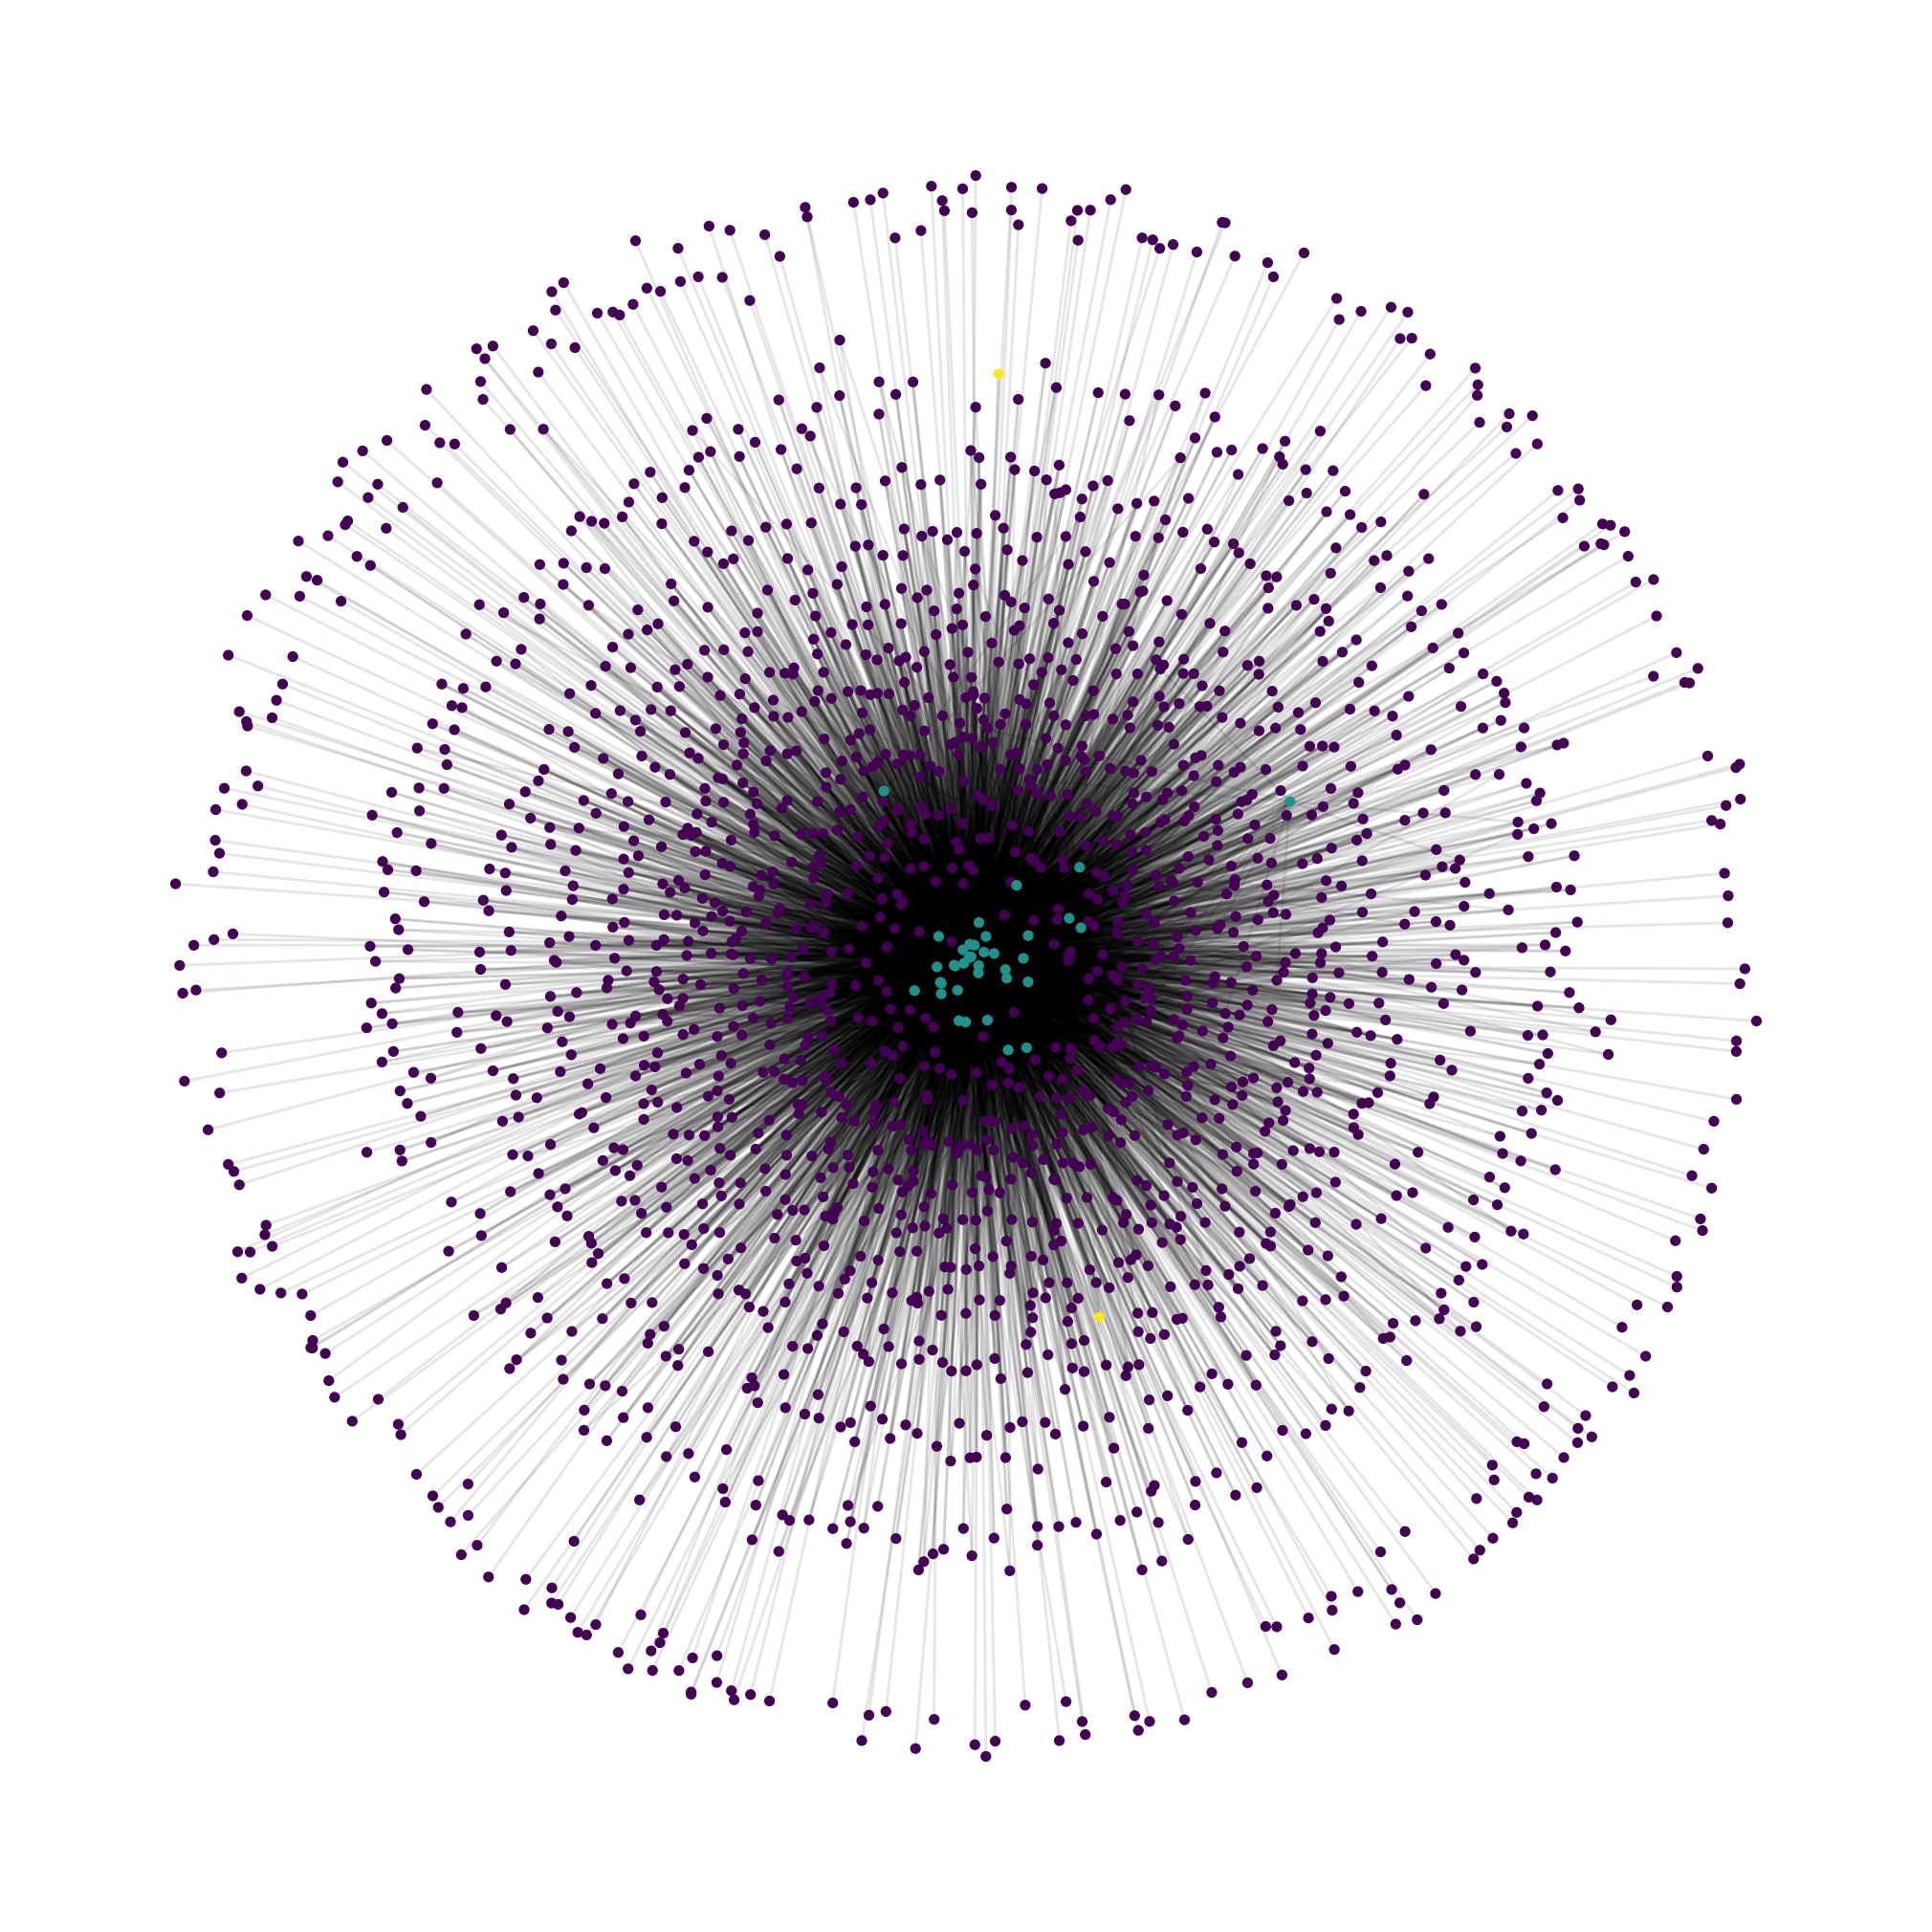

In [13]:
# Graph the large subgraph
color_map = {"playlist": 0, "track": 1, "artist": 2}

node_color = []
for node, attr in sub_G_lg.nodes(data=True):
    # Safely get the node type (default to track if unknown)
    node_type = attr.get("node_type", "track")
    node_color.append(color_map.get(node_type, 1))

plt.figure(figsize=(20,20))
nx.draw(sub_G_lg,
        cmap=plt.get_cmap('viridis'), 
        node_color=node_color,
        node_size = 50,
        width = 2,
        edge_color=(0, 0, 0, 0.1))
plt.show()

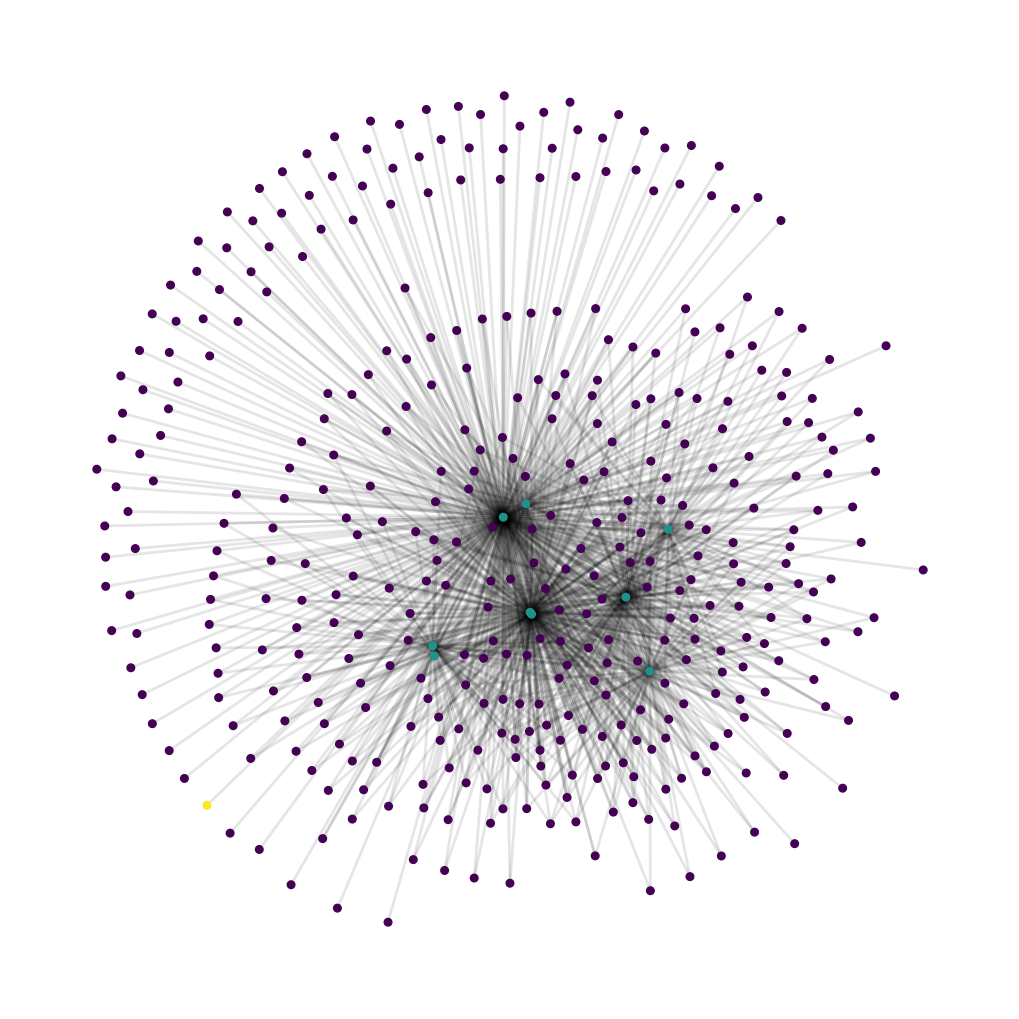

In [14]:
# Graph the subgraph of the small subgraph
color_map = {"playlist": 0, "track": 1, "artist": 2}

node_color = []
for node, attr in sub_G_sm.nodes(data=True):
    # Safely get the node type (default to track if unknown)
    node_type = attr.get("node_type", "track")
    node_color.append(color_map.get(node_type, 1))

plt.figure(figsize=(10,10))
nx.draw(sub_G_sm,
        cmap=plt.get_cmap('viridis'),
        node_color=node_color,
        node_size = 30,
        width = 2,
        edge_color=(0, 0, 0, 0.1))
plt.show()

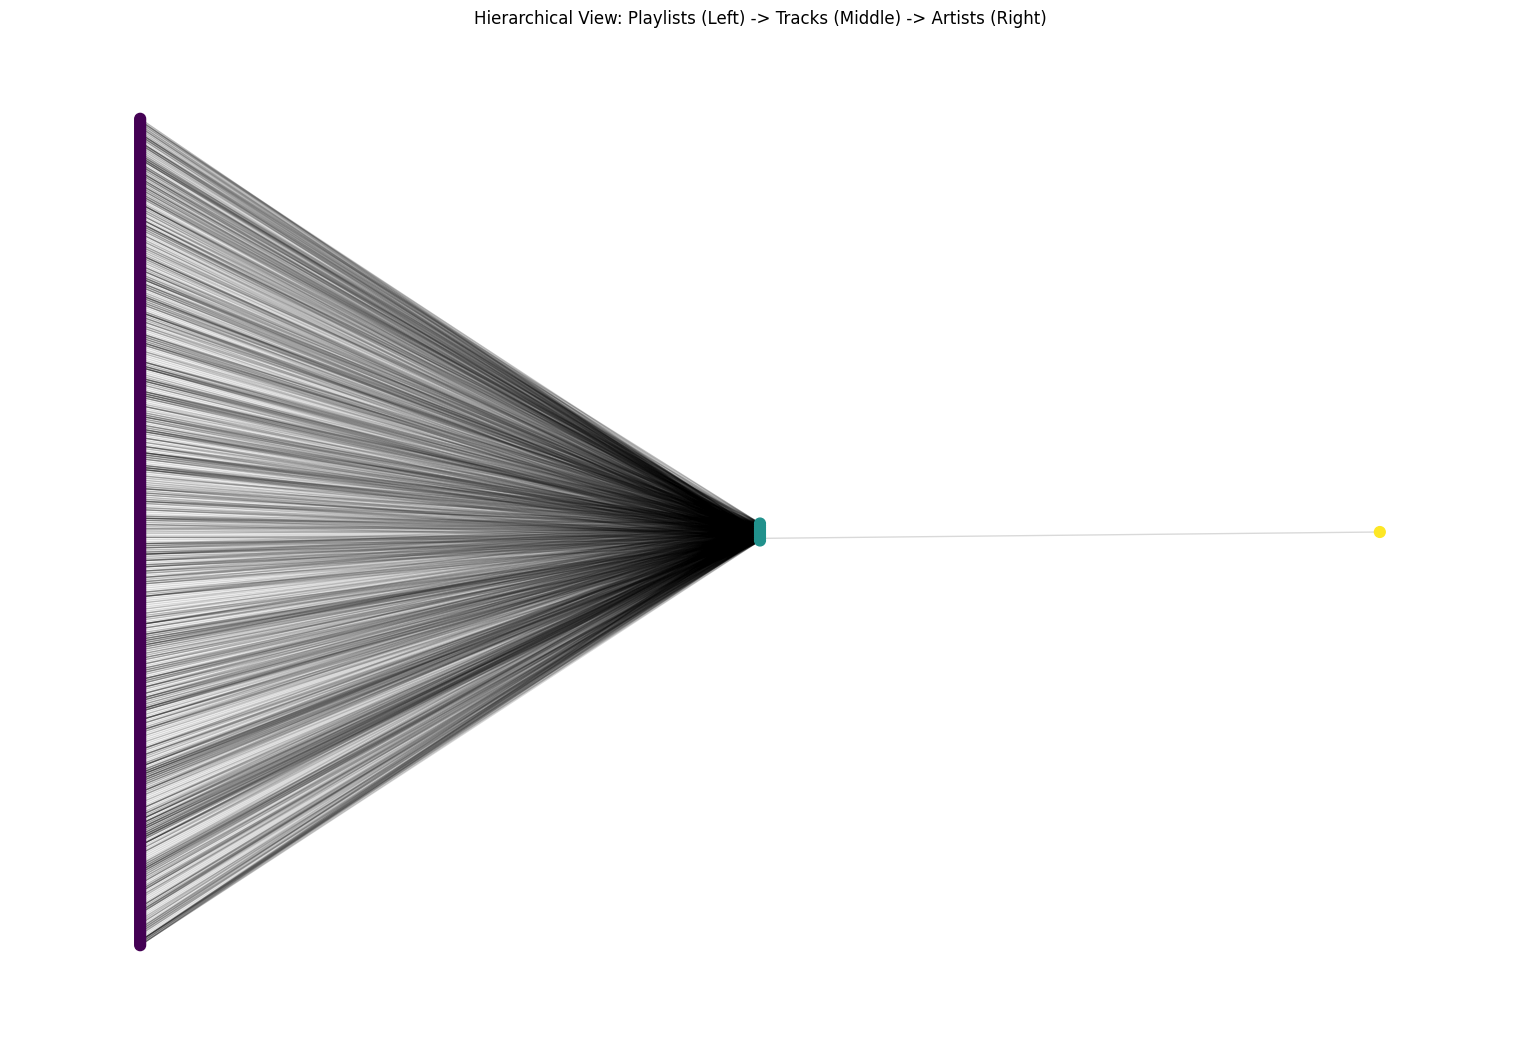

In [15]:
# Visualize as a 3-Layer Hierarchy
# Layer 0: Playlists | Layer 1: Tracks | Layer 2: Artists

# 1. Assign "subset" attribute for the layout engine
for n, d in sub_G_sm.nodes(data=True):
    nt = d.get('node_type', 'track')
    if nt == 'playlist':
        sub_G_sm.nodes[n]['subset'] = 0
    elif nt == 'track':
        sub_G_sm.nodes[n]['subset'] = 1
    else: # artist
        sub_G_sm.nodes[n]['subset'] = 2

# 2. Calculate positions
pos = nx.multipartite_layout(sub_G_sm, subset_key="subset")

# 3. Draw the graph
plt.figure(figsize=(15, 10))

# Ensure colors are consistent
color_map = {"playlist": 0, "track": 1, "artist": 2}
colors = [color_map.get(d.get('node_type'), 1) for n, d in sub_G_sm.nodes(data=True)]

nx.draw(sub_G_sm, 
        pos=pos,
        cmap=plt.get_cmap('viridis'),
        node_color=colors,
        node_size=60,
        width=1,
        edge_color=(0, 0, 0, 0.15))

plt.title("Hierarchical View: Playlists (Left) -> Tracks (Middle) -> Artists (Right)")
plt.show()

Visualizing neighborhood of Artist: spotify:artist:3TVXtAsR1Inumwj472S9r4


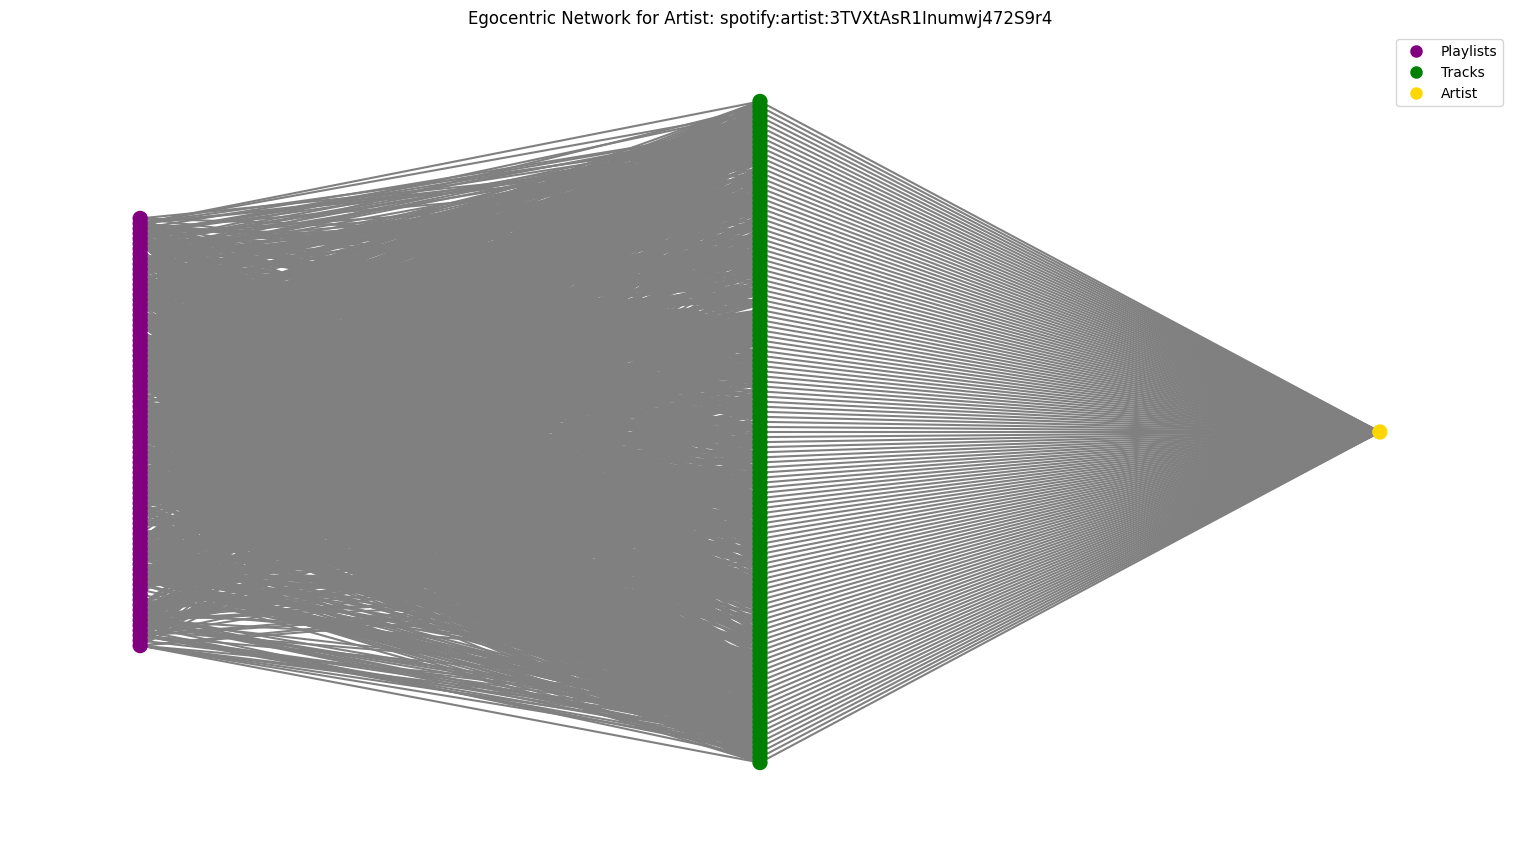

In [16]:
# --- 3-LAYER VISUALIZATION ---

# 1. Find an Artist node in the full graph (G)
artists = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'artist']

if not artists:
    print("Error: No artists found in the entire graph! Check the collection step.")
else:
    # Pick an artist who actually has connections
    # We sort by degree to find a "popular" artist so the graph looks interesting
    popular_artist = sorted(artists, key=lambda n: G.degree(n), reverse=True)[0]
    
    print(f"Visualizing neighborhood of Artist: {popular_artist}")

    # 2. Get neighbors (Tracks) and neighbors of neighbors (Playlists)
    # Hop 1: Artist -> Tracks
    tracks = list(G.neighbors(popular_artist))
    
    # Hop 2: Tracks -> Playlists (limit to 50 playlists to keep plot clean)
    playlists = set()
    for t in tracks:
        for neighbor in G.neighbors(t):
            if G.nodes[neighbor].get('node_type') == 'playlist':
                playlists.add(neighbor)
            if len(playlists) > 50: break
    
    # 3. Build the specific subgraph
    viz_nodes = set([popular_artist]) | set(tracks) | playlists
    viz_G = G.subgraph(viz_nodes)

    # 4. Set up the 3-Layer Layout
    for n, d in viz_G.nodes(data=True):
        nt = d.get('node_type', 'track')
        if nt == 'playlist':
            viz_G.nodes[n]['subset'] = 0 # Left
        elif nt == 'track':
            viz_G.nodes[n]['subset'] = 1 # Middle
        else: # artist
            viz_G.nodes[n]['subset'] = 2 # Right

    pos = nx.multipartite_layout(viz_G, subset_key="subset")

    # 5. Draw
    plt.figure(figsize=(15, 8))
    
    # Define colors: Purple (Playlist) -> Green (Track) -> Yellow (Artist)
    color_map = {"playlist": "#800080", "track": "#008000", "artist": "#FFD700"}
    node_colors = [color_map.get(d.get('node_type'), 'grey') for n, d in viz_G.nodes(data=True)]
    
    nx.draw(viz_G, pos=pos, node_color=node_colors, node_size=100, width=1.5, edge_color="gray", with_labels=False)
    
    # Add Legend manually
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Playlists', markerfacecolor='#800080', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Tracks', markerfacecolor='#008000', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Artist', markerfacecolor='#FFD700', markersize=10)
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title(f"Egocentric Network for Artist: {popular_artist}")
    plt.show()

## Constructing a graph dataset

In order to use our graph with the graph. machine learning packages we installed, we need to do a bit of processing of the graph first.

In [17]:
# Note: If you've already generated the graph above, keep reload = False.
reload = False

if reload:
    G = pickle.load(open(f"30core_first_50_extended.pkl", "rb"))

print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 37373 . Num edges: 1555870


In [18]:
import torch
import numpy as np

n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()

# 1. Create Mappings
# We sort to ensure deterministic ordering
sorted_nodes = sorted(list(G.nodes()))
node2id = dict(zip(sorted_nodes, np.arange(n_nodes)))
id2node = dict(zip(np.arange(n_nodes), sorted_nodes))

# 2. Relabel the graph to integer IDs
G = nx.relabel_nodes(G, node2id)

# 3. Count Node Types Correctly
playlists_idx = [i for i, n in id2node.items() if "playlist" in str(n)]
tracks_idx = [i for i, n in id2node.items() if "track" in str(n)]
artists_idx = [i for i, n in id2node.items() if "artist" in str(n)]

n_playlists = len(playlists_idx)
n_tracks = len(tracks_idx)
n_artists = len(artists_idx)

print(f"Graph Stats:")
print(f"  - Playlists: {n_playlists}")
print(f"  - Tracks:    {n_tracks}")
print(f"  - Artists:   {n_artists} (The Extension!)")
print(f"  - Total:     {n_nodes}")

# 4. Separate Edges into Tensors
interaction_edges = []
structural_edges = []

print("Separating edges into Interaction (P-T) and Structural (T-A)...")
for u, v in tqdm(G.edges(), desc="Processing Edges"):
    # Get node types using the integer IDs
    u_type = G.nodes[u].get('node_type', 'unknown')
    v_type = G.nodes[v].get('node_type', 'unknown')
    
    # Logic: If either side is an Artist, it's a structural edge
    if u_type == 'artist' or v_type == 'artist':
        structural_edges.append((u, v))
        structural_edges.append((v, u)) # Undirected
    else:
        interaction_edges.append((u, v))
        interaction_edges.append((v, u)) # Undirected

# Convert to PyTorch Tensors
interaction_edge_index = torch.tensor(interaction_edges, dtype=torch.long).t().contiguous()
structural_edge_index = torch.tensor(structural_edges, dtype=torch.long).t().contiguous()

print(f"Edge Tensors Created:")
print(f"  - Interaction Edges (to be split): {interaction_edge_index.shape[1]}")
print(f"  - Structural Edges (always kept):  {structural_edge_index.shape[1]}")

Graph Stats:
  - Playlists: 22083
  - Tracks:    12237
  - Artists:   3053 (The Extension!)
  - Total:     37373
Separating edges into Interaction (P-T) and Structural (T-A)...


Processing Edges: 100%|██████████| 1555870/1555870 [00:02<00:00, 638795.63it/s]


Edge Tensors Created:
  - Interaction Edges (to be split): 3087266
  - Structural Edges (always kept):  24474


In [19]:
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit

# 1. Create Data Object with ONLY Interaction Edges first
# We do this so the splitter only tries to hide/predict Playlist-Track links
data = Data(edge_index=interaction_edge_index, num_nodes=n_nodes)

# 2. Define the Splitter
# We use 15% for validation and 15% for testing
transform = RandomLinkSplit(
    is_undirected=True, 
    add_negative_train_samples=False,
    neg_sampling_ratio=0.0,
    num_val=0.15, 
    num_test=0.15
)

print("Splitting interaction edges (Playlist-Track)...")
train_split, val_split, test_split = transform(data)

# 3. INJECT STRUCTURAL EDGES
# We add the Artist connections (structural_edge_index) back to the 
# 'message passing' graph for ALL splits. 

def inject_structural(data_obj, struct_edges):
    # Concatenate existing message-passing edges with our fixed structural edges
    data_obj.edge_index = torch.cat([data_obj.edge_index, struct_edges], dim=1)
    return data_obj

print("Injecting structural (Artist) edges into all sets...")
train_split = inject_structural(train_split, structural_edge_index)
val_split = inject_structural(val_split, structural_edge_index)
test_split = inject_structural(test_split, structural_edge_index)

print("Split successful!")
print(f"Train Edges (Interactions + Artists): {train_split.edge_index.shape[1]}")
print(f"Val Edges (Train + Artists):          {val_split.edge_index.shape[1]}")
print(f"Test Edges (Train + Val + Artists):   {test_split.edge_index.shape[1]}")

Splitting interaction edges (Playlist-Track)...
Injecting structural (Artist) edges into all sets...
Split successful!
Train Edges (Interactions + Artists): 2185564
Val Edges (Train + Artists):          2185564
Test Edges (Train + Val + Artists):   2648652


In [20]:
# note these are stored as float32, we need them to be int64 for future training

# Edge index: message passing edges
train_split.edge_index = train_split.edge_index.type(torch.int64)
val_split.edge_index = val_split.edge_index.type(torch.int64)
test_split.edge_index = test_split.edge_index.type(torch.int64)
# Edge label index: supervision edges
train_split.edge_label_index = train_split.edge_label_index.type(torch.int64)
val_split.edge_label_index = val_split.edge_label_index.type(torch.int64)
test_split.edge_label_index = test_split.edge_label_index.type(torch.int64)

print(f"Train set has {train_split.edge_label_index.shape[1]} positives supervision edges")
print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")
print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")
print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")

Train set has 1080545 positives supervision edges
Validation set has 231544 positive supervision edges
Test set has 231544 positive supervision edges
Train set has 2185564 message passing edges
Validation set has 2185564 message passing edges
Test set has 2648652 message passing edges


In [21]:
# --- RGCN PREPARATION: CREATE EDGE TYPES ---
# We need to tell the model which edges are Playlist-Track (0) and which are Track-Artist (1)

def add_edge_types(data_obj, num_structural):
    total_edges = data_obj.edge_index.shape[1]
    num_interactions = total_edges - num_structural
    
    # Type 0 = Interaction (Playlist <-> Track)
    # Type 1 = Structural (Track <-> Artist)
    type_zeros = torch.zeros(num_interactions, dtype=torch.long)
    type_ones = torch.ones(num_structural, dtype=torch.long)
    
    data_obj.edge_type = torch.cat([type_zeros, type_ones])
    return data_obj

# Calculate how many structural edges we injected
num_struct = structural_edge_index.shape[1]

print(f"Tagging edges (0=Interaction, 1=Artist_Fact)...")
train_split = add_edge_types(train_split, num_struct)
val_split = add_edge_types(val_split, num_struct)
test_split = add_edge_types(test_split, num_struct)

print("Edge types created successfully!")

Tagging edges (0=Interaction, 1=Artist_Fact)...
Edge types created successfully!


We are now ready to get started implementing our model!

## Designing our model

**I Keep this part from the article. It's good to know their models' formulas.**

To implement our model, we will be using the LightGCN architecture. This architecture forms a simple GNN method where we remove nonlinearity across layers. This leads to a highly scalable architecture with fewer parameters. By taking a weighted sum of the embeddings at different hop scales (also called multi-scale diffusion), LightGCN has exhibited better performance than other neural graph collaborative filtering approaches while also being computationally efficient.


To implement our models, we will customize the implementation of LightGCN from PyG.

One important note: the GNN method we are defining below acts as our full graph neural network, consisting of multiple message passing layers that are connected with skip connections (weighted according to the alpha parameter). We surface functionality to change the message passing layer from the default LightGCN layer to alternatives, such as a GAT and GraphSAGE convolution instead, as well as to have a learnable alpha parameter.

The three convolutional layers we use are the LGConv (from LightGCN), SAGEConv (GraphSAGE), and GATConv (GAT). We add a linear layer on top of the GATConv to take the concatenated outputs from the multiple attention heads back to the embedding dimension. Below we provide the update steps for each type of layer.

1. LGConv

\begin{equation*}
\mathbf{e}_i^{(k+1)} = \underset{j \in \mathcal{N}(i)}{\sum} \frac{1}{
  \sqrt{| \mathcal{N}(i)|} \sqrt{| \mathcal{N}(j)|} } \mathbf{e}_j^{(k)}
\end{equation*}


2. SAGEConv

\begin{equation*}
\mathbf{e}^{(k+1)}_{i} = \mathbf{W}_1 \mathbf{e}^{(k)}_{i} + \mathbf{W}_2 \frac{1}{| \mathcal{N}(i)|} \underset{j \in \mathcal{N}(i)}{\sum} \mathbf{e}^{(k)}_j
\end{equation*}

3. GATConv

\begin{align*}
    \mathbf{e}^{(k+1)}_i &= \mathbf{\Theta}\mathbf{x}_i^{(k+1)} + \mathbf{B} \\
    \mathbf{x}_i^{(k+1)} &= \underset{h=1}{\Big\Vert^H} \sum_{j \in \mathcal{N}(i) \cup \{i\} } \alpha_{ij}^h \mathbf{W}^h
    \mathbf{e}^{(k)}_j \\
    \alpha^h_{ij} &= \frac{
    \exp(
    \text{LeakyReLU}(\mathbf{a}^{h^{T}} \left[\mathbf{W}^h \mathbf{e}_i \Vert \mathbf{W}^h \mathbf{e}_j \right]))
    }{
    \underset{l \in \mathcal{N}(i) \cup \{i\}}{\sum}     \exp(
    \text{LeakyReLU}(\mathbf{a}^{h^{T}} \left[\mathbf{W}^h \mathbf{e}_i \Vert \mathbf{W}^h \mathbf{e}_l \right]))
    }
\end{align*}

No matter which convolutional layer we use, we still take the weighted sum of the different layers as is standard in LightGCN. We do so as follows:

\begin{equation*}
    \mathbf{e}_i = \sum_{k=1}^K \alpha_k \mathbf{e}^{(k)}_i
\end{equation*}


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import LGConv, SAGEConv, GATConv, RGCNConv, GCNConv

class GCN(nn.Module):
    def __init__(
        self,
        num_nodes: int,
        embedding_dim: int,
        num_layers: int,
        conv_layer: str = "LGC", 
        num_relations: int = 2, # For RGCN (0=Playlist, 1=Artist)
        **kwargs,
    ):
        super().__init__()
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.conv_layer = conv_layer
        self.name = f"{conv_layer}_{num_layers}_layer"

        # 1. Initial Embeddings
        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        nn.init.normal_(self.embedding.weight, std=0.1)

        # 2. Define Layers
        self.convs = nn.ModuleList()
        
        for _ in range(num_layers):
            if conv_layer == "LGC":
                self.convs.append(LGConv(**kwargs))
                
            elif conv_layer == "SAGE":
                self.convs.append(SAGEConv(embedding_dim, embedding_dim, **kwargs))
                
            elif conv_layer == "GAT":
                self.convs.append(GATConv(embedding_dim, embedding_dim, heads=1, dropout=0.5))
                
            elif conv_layer == "GCN":
                self.convs.append(GCNConv(embedding_dim, embedding_dim, **kwargs))
                
            elif conv_layer == "RGCN":
                self.convs.append(RGCNConv(embedding_dim, embedding_dim, num_relations=num_relations))

    def forward(self, edge_index, edge_type=None):
        # Layer 0
        x = self.embedding.weight
        embeddings_list = [x]

        for i, conv in enumerate(self.convs):
            # RGCN requires edge_type, others do not
            if self.conv_layer == "RGCN":
                if edge_type is None:
                    # Fallback: treat all edges as type 0 if missing
                    edge_type = torch.zeros(edge_index.size(1), dtype=torch.long, device=edge_index.device)
                x = conv(x, edge_index, edge_type)
            else:
                x = conv(x, edge_index)

            # Activation functions (LightGCN doesn't use them, others do)
            if self.conv_layer in ["SAGE", "GAT", "GCN", "RGCN"]:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
            
            embeddings_list.append(x)

        # Aggregation: Mean of all layers
        final_embeddings = torch.stack(embeddings_list, dim=0).mean(dim=0)
        return final_embeddings

    def get_embedding(self, edge_index, edge_type=None):
        """Helper alias for forward(), required by recall_at_k"""
        return self.forward(edge_index, edge_type)

    def decode(self, z, edge_label_index):
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        return (src * dst).sum(dim=-1)
    
    def predict_link_embedding(self, embed, edge_label_index):
        """Helper for compatibility with older code"""
        return self.decode(embed, edge_label_index)

Our main specifications will use a Bayesian Personalized Ranking, which is calculated as

\begin{equation*}
    \text{BPR Loss}(i) = \frac{1}{|\mathcal{E}(i)|} \underset{{(i, j_{+}) \in \mathcal{E}(i)}}{\sum} \log \sigma \left( \text{score}(i, j_+) - \text{score}(i, j_-) \right)
\end{equation*}

for a pair of positive edge $(i, j_{+})$ and negative edge $(i, j_{-})$. More on how we define a negative edge later.

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn.modules.loss import _Loss

class BPRLoss(_Loss):
    r"""The Bayesian Personalized Ranking (BPR) loss.

    The BPR loss is a pairwise loss that encourages the prediction of an
    observed entry to be higher than its unobserved counterparts
    (see `here <https://arxiv.org/abs/2002.02126>`__).

    .. math::
        L_{\text{BPR}} = - \sum_{u=1}^{M} \sum_{i \in \mathcal{N}_u}
        \sum_{j \not\in \mathcal{N}_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj})
        + \lambda \vert\vert \textbf{x}^{(0)} \vert\vert^2

    where :math:`lambda` controls the :math:`L_2` regularization strength.
    We compute the mean BPR loss for simplicity.

    Args:
        lambda_reg (float, optional): The :math:`L_2` regularization strength
            (default: 0).
        **kwargs (optional): Additional arguments of the underlying
            :class:`torch.nn.modules.loss._Loss` class.
    """
    __constants__ = ['lambda_reg']
    lambda_reg: float

    def __init__(self, lambda_reg: float = 0, **kwargs):
        super().__init__(None, None, "sum", **kwargs)
        self.lambda_reg = lambda_reg

    def forward(self, positives: Tensor, negatives: Tensor,
                parameters: Tensor = None) -> Tensor:
        r"""Compute the mean Bayesian Personalized Ranking (BPR) loss.

        .. note::

            The i-th entry in the :obj:`positives` vector and i-th entry
            in the :obj:`negatives` entry should correspond to the same
            entity (*.e.g*, user), as the BPR is a personalized ranking loss.

        Args:
            positives (Tensor): The vector of positive-pair rankings.
            negatives (Tensor): The vector of negative-pair rankings.
            parameters (Tensor, optional): The tensor of parameters which
                should be used for :math:`L_2` regularization
                (default: :obj:`None`).
        """
        n_pairs = positives.size(0)
        log_prob = F.logsigmoid(positives - negatives).sum()
        regularization = 0

        if self.lambda_reg != 0:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2)

        return (-log_prob + regularization) / n_pairs

## Defining training, test functions

Important to any link prediction task is negative sampling. In the graph, we observe positive edges, which allows us to capture which nodes should be most similar to one another. Adding negative edges allows the model to explicitly capture that nodes that don't share an edge should have different embeddings. Without negative edges, you can convince yourself that a valid loss minimization strategy would be to simply assign all nodes the same embedding, which is obviously not meaningful or desirable.

Consequently, in this section, we define our negative sampling strategy. In particular, we take three approaches:
1. Random, no positive check: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the full set of track nodes such that ($p_i$, $t_j$) is the negative edge. For computational efficiency, we don't check if ($p_i$, $t_j$) is actually a negative edge, though probabilistically it is very likely.
2. Random, positive check: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the full set of track nodes such that ($p_i$, $t_j$) is the negative edge. We ensure that ($p_i$, $t_j$) is not a positive edge.
3. Hard: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the top $k$ proportion of tracks, ranked by dot product similarity to $p_i$. For epoch 0, $k = 1$ and we lower it at each subsequent iteration.

### Negative sampling

In [24]:
# --- ROBUST NEGATIVE SAMPLING (Using Node Attributes) ---
import torch

# 1. Helper to find index ranges using GRAPH ATTRIBUTES
# Instead of guessing from string names, we look at the 'node_type' we stored.

def get_node_ranges_from_graph(graph):
    # Find all integer indices where the node attribute 'node_type' is 'track'
    track_indices = [n for n, d in graph.nodes(data=True) if d.get('node_type') == 'track']
    
    if not track_indices:
        # Fallback for safety: If attributes are lost, assume range based on counts
        print("Warning: Node attributes missing. Using fallback estimation.")
        return 0, 0, 0
        
    min_track = min(track_indices)
    max_track = max(track_indices)
    return min_track, max_track, len(track_indices)

# Calculate ranges
TRACK_START_IDX, TRACK_END_IDX, NUM_TRACKS = get_node_ranges_from_graph(G)
print(f"Sampling Configuration: Tracks are indices {TRACK_START_IDX} to {TRACK_END_IDX} (Count: {NUM_TRACKS})")

def sample_negative_edges_nocheck(data, device=None):
    """
    Simple random sampling: Picks a random Track for each Playlist edge.
    """
    playlists = data.edge_label_index[0, :]
    
    # Random integers within the specific TRACK range
    neg_tracks = torch.randint(
        TRACK_START_IDX, 
        TRACK_END_IDX + 1, 
        size=(playlists.size(0),), 
        device=device
    )
    
    neg_edge_index = torch.stack((playlists, neg_tracks), dim=0)
    return neg_edge_index


def sample_hard_negative_edges(data, model, device=None, batch_size=500, frac_sample=1.0):
    """
    Hard Negative Sampling using Model Embeddings
    """
    model.eval()
    with torch.no_grad():
        # Get embeddings
        edge_type = data.edge_type.to(device) if hasattr(data, 'edge_type') else None
        embeddings = model.get_embedding(data.edge_index.to(device)) 
        
        # Extract embeddings using the robust ranges
        # Note: This assumes playlists are roughly 0..n_playlists. 
        # If ranges are non-contiguous, this simple slicing might need adjustment, 
        # but typically sorting nodes groups types together.
        playlists_embeddings = embeddings[:n_playlists]
        tracks_embeddings = embeddings[TRACK_START_IDX : TRACK_END_IDX + 1]

    positive_playlists, positive_tracks = data.edge_label_index
    num_edges = positive_playlists.size(0)

    # Iterate through playlists in chunks
    neg_edges_list = []
    unique_playlists = positive_playlists.unique()
    
    for i in range(0, len(unique_playlists), batch_size):
        batch_playlists = unique_playlists[i : i + batch_size]
        
        # Score: Batch_Playlists x All_Tracks
        batch_scores = torch.matmul(
            playlists_embeddings[batch_playlists], 
            tracks_embeddings.t()
        )
        
        # Pick top candidates (Hardest negatives)
        # We clamp k to ensure it's at least 1 and not larger than available tracks
        k = max(1, int(frac_sample * 0.05 * NUM_TRACKS)) 
        k = min(k, NUM_TRACKS)
        
        _, top_indices = torch.topk(batch_scores, k, dim=1)
        
        # Select random hard negative
        random_selection = torch.randint(0, k, (len(batch_playlists),), device=device)
        hard_neg_local = top_indices[torch.arange(len(batch_playlists)), random_selection]
        
        # Convert local track index back to global ID
        hard_neg_global = hard_neg_local + TRACK_START_IDX
        
        # Create edges
        batch_neg_edges = torch.stack([batch_playlists, hard_neg_global], dim=0)
        neg_edges_list.append(batch_neg_edges)

    # Concatenate
    if neg_edges_list:
        neg_edge_index = torch.cat(neg_edges_list, dim=1)
        
        # Resize to match positive count
        if neg_edge_index.size(1) < num_edges:
            repeats = (num_edges // neg_edge_index.size(1)) + 1
            neg_edge_index = neg_edge_index.repeat(1, repeats)[:, :num_edges]
        else:
            neg_edge_index = neg_edge_index[:, :num_edges]
            
        return neg_edge_index
    else:
        # Fallback if list empty
        return sample_negative_edges_nocheck(data, device)

print("Negative Sampling (Robust) Updated!")

Sampling Configuration: Tracks are indices 25136 to 37372 (Count: 12237)
Negative Sampling (Robust) Updated!


### Evaluation

In addition, to calculating the loss, we would like to have other metrics to evaluate the quality of our predictions.

First, we consider one common metric for recommender systems: Recall@K. This is defined as follows: for a playlist $i$, $P^k_i$ represents the set of the top $k$ predicted tracks for $i$ and $R_i$ the ground truth of connected tracks to playlist $i$, then we calculate
$$
\text{recall}^k_i = \frac{| P^k_i \cap R_i | }{|R_i|}.
$$
If $R_i = 0$, then we assign this value to 1. Note, if $R_i \subset P_i^k$, then the recall is equal to 1. Hence, our choice of $k$ matters a lot.

Note: when evaluating this metric on our validation or test set, we need to make sure to filter the message passing edges from consideration, as the model can directly observe these.

We choose a value of $k = 300$, which seems reasonable given the overall number of possible tracks is 12,247.

In [25]:
# RECALL@K 
def recall_at_k(data, model, k=300, batch_size=64, device=None):
    model.eval()
    with torch.no_grad():
        # 1. Get Embeddings
        edge_type = data.edge_type.to(device) if hasattr(data, 'edge_type') else None
        embeddings = model.get_embedding(data.edge_index.to(device), edge_type=edge_type)
        
        # 2. Robust Slicing (Only Playlists and Tracks, ignore Artists)
        # We assume playlists are at the start (0..n_playlists)
        playlists_embeddings = embeddings[:n_playlists]
        
        # We use the TRACK indices we found earlier to ignore Artists
        tracks_embeddings = embeddings[TRACK_START_IDX : TRACK_END_IDX + 1]

    hits_list = []
    relevant_counts_list = []

    # We need to know the global offset to map Global_ID -> Matrix_Index
    # For the tracks matrix, Index 0 corresponds to global ID 'TRACK_START_IDX'
    track_offset = TRACK_START_IDX

    for batch_start in range(0, n_playlists, batch_size):
        batch_end = min(batch_start + batch_size, n_playlists)
        
        # Get batch of User embeddings
        batch_playlists_embeddings = playlists_embeddings[batch_start:batch_end]

        # Calculate scores: (Batch_Size x Num_Tracks)
        scores = torch.matmul(batch_playlists_embeddings, tracks_embeddings.t())

        # --- MASKING TRAINING EDGES ---
        # We don't want to recommend tracks that are already in the message passing graph (training edges)
        # We filter edges where the user is in the current batch
        
        # 1. Find edges relevant to this batch of playlists
        # Note: data.edge_index[0] are the source nodes (Playlists)
        mp_mask = (data.edge_index[0] >= batch_start) & (data.edge_index[0] < batch_end)
        mp_indices = mp_mask.nonzero(as_tuple=True)[0]
        
        # 2. Get the specific (User, Track) pairs from the graph
        u_indices = data.edge_index[0, mp_indices] - batch_start # Map to local batch index (0..64)
        v_indices_global = data.edge_index[1, mp_indices]        # Global Track ID
        
        # 3. Filter: We only care about edges where the destination is actually a TRACK
        # (Message passing graph also contains Artist edges, we must ignore those here)
        valid_tracks_mask = (v_indices_global >= TRACK_START_IDX) & (v_indices_global <= TRACK_END_IDX)
        
        # Apply mask to keep only valid track interactions
        u_indices = u_indices[valid_tracks_mask]
        v_indices_local = v_indices_global[valid_tracks_mask] - track_offset
        
        # 4. Set scores to -inf so they aren't recommended again
        scores[u_indices, v_indices_local] = -float("inf")

        # --- SCORING ---
        # Find top K
        _, top_k_indices = torch.topk(scores, k, dim=1)

        # --- GROUND TRUTH CHECKING ---
        # We check against the supervision edges (Test Set labels)
        gt_edges = data.edge_label_index
        
        gt_mask = (gt_edges[0] >= batch_start) & (gt_edges[0] < batch_end)
        gt_indices = gt_mask.nonzero(as_tuple=True)[0]
        
        # Ground Truth (User, Track) pairs
        gt_u = gt_edges[0, gt_indices] - batch_start
        gt_v = gt_edges[1, gt_indices] - track_offset # Map global ID to local matrix index
        
        # Create a boolean mask of True Positives
        # Shape: (Batch_Size, Num_Tracks)
        truth_matrix = torch.zeros(scores.shape, device=device, dtype=torch.bool)
        truth_matrix[gt_u, gt_v] = True

        # Check overlaps
        hits = truth_matrix.gather(1, top_k_indices).sum(dim=1)
        hits_list.append(hits)

        # Count how many relevant items were actually in this batch (for normalization)
        relevant_counts = torch.bincount(gt_u, minlength=batch_end - batch_start)
        relevant_counts_list.append(relevant_counts)

    # Aggregate
    hits_tensor = torch.cat(hits_list, dim=0)
    relevant_counts_tensor = torch.cat(relevant_counts_list, dim=0)

    # Recall = Hits / Total_Relevant
    # Avoid division by zero
    recall = torch.where(
        relevant_counts_tensor != 0,
        hits_tensor.float() / relevant_counts_tensor.float(),
        torch.tensor(0.0, device=device) # If no relevant items, recall is defined as 0 (or 1 depending on strictness, usually 0 here)
    )

    return torch.mean(recall).item()

print("Recall Function Updated for Heterogeneous Graph!")

Recall Function Updated for Heterogeneous Graph!


In addition, we calculate the ROC AUC score for the binary predictions, which provides a measure of the efficiency of our model at distinguishing `true' track-playlist edges from non-existing ones. The higher this score, the better (a perfect score is achieved when ROC AUC = 1).

In [26]:
from sklearn.metrics import roc_auc_score
import torch
import numpy as np

def metrics(labels, preds):
    # 1. Handle PyTorch Tensors (used during Training)
    if torch.is_tensor(labels):
        labels = labels.cpu().numpy()
    if torch.is_tensor(preds):
        preds = preds.detach().cpu().numpy()
        
    # 2. Handle Numpy Arrays (used during Testing)
    # If they are already numpy, we just flatten them
    return roc_auc_score(labels.flatten(), preds.flatten())

# --- Another METRIC: NOVELTY ---
print("Calculating item popularity for Novelty metric...")
item_popularity = torch.zeros(n_nodes, dtype=torch.long)
deg = torch.bincount(interaction_edge_index.flatten())

if deg.size(0) < n_nodes:
    deg = torch.cat([deg, torch.zeros(n_nodes - deg.size(0), dtype=torch.long)])
item_popularity = deg

def novelty_score(recommended_indices):
    if isinstance(recommended_indices, torch.Tensor):
        recommended_indices = recommended_indices.cpu()
    
    pop_counts = item_popularity[recommended_indices]
    total_interactions = interaction_edge_index.size(1)
    probs = (pop_counts + 1).float() / total_interactions
    self_info = -torch.log2(probs)
    
    return self_info.mean().item()

print("Metrics defined: ROC AUC and Novelty Score.")

Calculating item popularity for Novelty metric...
Metrics defined: ROC AUC and Novelty Score.


### Main train / test functions

Now we define our main train and test functions, which will handle model training and evaluation.

In [27]:
import os
import torch
import pickle
import time

def train(datasets, model, optimizer, loss_fn, args, neg_samp="random"):
    print(f"Beginning training for {model.name}...")
    
    train_data = datasets["train"]
    val_data = datasets["val"]
    
    # Dictionary to store results for plotting later
    stats = {
        'train': {'loss': [], 'roc': []},
        'val':   {'loss': [], 'roc': [], 'recall': [], 'novelty': []} # Added Novelty metric!
    }
    
    start_time = time.time()
    
    for epoch in range(args["epochs"]):
        model.train()
        optimizer.zero_grad()
        
        # --- 1. NEGATIVE SAMPLING ---
        if neg_samp == "random":
            # Use our safe, track-aware sampler (Avoids Artists)
            neg_edge_index = sample_negative_edges_nocheck(train_data, device=args["device"])
        elif neg_samp == "hard":
            # Hard negative mining (Training gets harder as epochs progress)
            if epoch % 5 == 0: 
                neg_edge_index = sample_hard_negative_edges(
                    train_data, model, device=args["device"], batch_size=2000, 
                    frac_sample=1 - (0.5 * epoch / args["epochs"])
                )
        
        # --- 2. FORWARD PASS ---
        # Handle Edge Types for RGCN
        # If the graph has edge types (0=Interaction, 1=Artist), pass them.
        edge_type = train_data.edge_type.to(args["device"]) if hasattr(train_data, 'edge_type') else None
        z = model(train_data.edge_index.to(args["device"]), edge_type)
        
        # --- 3. DECODE SCORES ---
        pos_edge_index = train_data.edge_label_index.to(args["device"])
        pos_scores = model.decode(z, pos_edge_index)
        neg_scores = model.decode(z, neg_edge_index)
        
        # Ensure sizes match for Loss calculation
        min_len = min(pos_scores.size(0), neg_scores.size(0))
        pos_scores = pos_scores[:min_len]
        neg_scores = neg_scores[:min_len]
        
        # --- 4. CALCULATE LOSS ---
        if isinstance(loss_fn, BPRLoss):
            # BPR Loss (Standard for Recommenders)
            loss = loss_fn(pos_scores, neg_scores, model.embedding.weight)
        else:
            # Fallback for BCE Loss
            preds = torch.cat([pos_scores, neg_scores])
            labels = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)])
            loss = loss_fn(preds, labels)
        
        loss.backward()
        optimizer.step()
        
        # --- 5. LOGGING TRAINING METRICS ---
        train_roc = metrics(
            torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)]),
            torch.cat([pos_scores.sigmoid(), neg_scores.sigmoid()])
        )
        
        stats['train']['loss'].append(loss.item())
        stats['train']['roc'].append(train_roc)
        
        # --- 6. VALIDATION STEP ---
        # Check performance every epoch
        if (epoch + 1) % 1 == 0: 
            val_roc, val_novelty = test(model, val_data, args["device"])
            stats['val']['roc'].append(val_roc)
            stats['val']['novelty'].append(val_novelty)
            
            elapsed = time.time() - start_time
            print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.4f} | Val AUC: {val_roc:.4f} | Val Novelty: {val_novelty:.4f}")
        
        # --- 7. RECALL CHECK ---
        # Only run every 5 epochs to save time
        if (epoch + 1) % 5 == 0:
            val_recall = recall_at_k(val_data, model, k=100, device=args["device"])
            stats['val']['recall'].append(val_recall)
            print(f"   >>> Val Recall@100: {val_recall:.4f}")

    print("Training finished.")
    return stats

@torch.no_grad()
def test(model, data, device):
    model.eval()
    
    # Forward Pass
    edge_type = data.edge_type.to(device) if hasattr(data, 'edge_type') else None
    z = model(data.edge_index.to(device), edge_type)
    
    # Positive Scores
    pos_edge_index = data.edge_label_index.to(device)
    pos_pred = model.decode(z, pos_edge_index).sigmoid()
    
    # Negative Scores (Random for testing)
    neg_edge_index = sample_negative_edges_nocheck(data, device=device)
    neg_pred = model.decode(z, neg_edge_index).sigmoid()
    
    # Metrics Calculation
    preds = torch.cat([pos_pred, neg_pred]).cpu().numpy()
    labels = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))]).numpy()
    
    roc = metrics(labels, preds)
    
    # --- NOVELTY ---
    # Calculate Novelty on the items the model predicted as "High Probability"
    # We take the top 20% highest scoring positive predictions
    k_top = max(1, int(pos_pred.size(0) * 0.2))
    _, top_indices = torch.topk(pos_pred, k_top)
    
    # Get the actual Track IDs for these top predictions
    top_tracks = pos_edge_index[1][top_indices]
    novelty = novelty_score(top_tracks)
    
    return roc, novelty

## Training models

### Set up hyperparameters and arguments

Run through these cells to set up all the hyperparameters and arguments we will need to run our models.

In [28]:
# Initialize arguments
args = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers': 3,
    'emb_size': 64,
    'weight_decay': 1e-5,
    'lr': 1e-3,          # Adjusted to standard LightGCN rate
    'epochs': 50         # 50 is usually enough to see convergence
}

# --- MODEL INITIALIZATION ---
# We initialize the model here so we can pass it to the train function
print(f"Initializing model on {args['device']}...")

# We can switch 'conv_layer' to "LGC", "SAGE", "GAT", or "RGCN"
model = GCN(
    num_nodes=n_nodes, 
    embedding_dim=args['emb_size'], 
    num_layers=args['num_layers'], 
    conv_layer="LGC",   # Start with LightGCN
    num_relations=2     # Required if using RGCN
).to(args['device'])

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Initialize Loss Function (BPR is best for this)
loss_fn = BPRLoss(lambda_reg=args['weight_decay'])

print("Model, Optimizer, and Loss ready.")

Initializing model on cuda...
Model, Optimizer, and Loss ready.


In [29]:
# create a dictionary of the dataset splits
datasets = {
    'train':train_split,
    'val':val_split,
    'test': test_split
}

In [30]:
# --- MODEL INITIALIZATION ---

num_nodes = n_nodes 

print(f"Initializing model with {num_nodes} nodes (Playlists + Tracks + Artists)...")

# Initialize Model
# We can change conv_layer to: "LGC" (LightGCN), "SAGE" (GraphSAGE), "GAT", or "RGCN"
model = GCN(
    num_nodes=num_nodes, 
    embedding_dim=args["emb_size"], 
    num_layers=args["num_layers"], 
    conv_layer="LGC",   # We use LightGCN as our main extension model
    num_relations=2     # Required parameter for RGCN (0=Playlist, 1=Artist)
).to(args["device"])

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# 4. Loss Function
# We use the BPR Loss class we defined earlier (Best for Recommendation)
loss_fn = BPRLoss(lambda_reg=args['weight_decay'])

print(f"Model '{model.name}' initialized on {args['device']}!")

Initializing model with 37373 nodes (Playlists + Tracks + Artists)...
Model 'LGC_3_layer' initialized on cuda!


In [31]:
# --- DEVICE MANAGEMENT ---
print(f"Moving data to {args['device']}...")

# 1. Convert Index Lists to Tensors
# We keep these handy for fast lookups/filtering later
playlists_tensor = torch.tensor(playlists_idx, dtype=torch.long).to(args["device"])
tracks_tensor = torch.tensor(tracks_idx, dtype=torch.long).to(args["device"])
artists_tensor = torch.tensor(artists_idx, dtype=torch.long).to(args["device"]) # The Extension!

# 2. Move Model (Safety check)
model = model.to(args["device"])

# 3. Move Datasets
# (If we run out of GPU memory, we can comment these lines out 
# and let the training loop move batches dynamically)
datasets['train'] = datasets['train'].to(args['device'])
datasets['val'] = datasets['val'].to(args['device'])
datasets['test'] = datasets['test'].to(args['device'])

print("Data and Model successfully moved to Device.")

Moving data to cuda...
Data and Model successfully moved to Device.


In [32]:
# create directory to save model_stats
MODEL_STATS_DIR = "model_stats"
if not os.path.exists(MODEL_STATS_DIR):
  os.makedirs(MODEL_STATS_DIR)

In [33]:
# Start Training
# We capture the output in 'stats' so we can plot the results later
stats = train(
    datasets, 
    model, 
    optimizer, 
    loss_fn,       # Pass the actual BPRLoss object, NOT the string "BPR"
    args, 
    neg_samp="random"
)

Beginning training for LGC_3_layer...
Epoch 01 | Loss: 0.6925 | Val AUC: 0.5056 | Val Novelty: 12.8865
Epoch 02 | Loss: 0.6925 | Val AUC: 0.5049 | Val Novelty: 12.8852
Epoch 03 | Loss: 0.6926 | Val AUC: 0.5052 | Val Novelty: 12.8843
Epoch 04 | Loss: 0.6926 | Val AUC: 0.5054 | Val Novelty: 12.8844
Epoch 05 | Loss: 0.6926 | Val AUC: 0.5060 | Val Novelty: 12.8833
   >>> Val Recall@100: 0.0081
Epoch 06 | Loss: 0.6926 | Val AUC: 0.5074 | Val Novelty: 12.8824
Epoch 07 | Loss: 0.6926 | Val AUC: 0.5072 | Val Novelty: 12.8817
Epoch 08 | Loss: 0.6926 | Val AUC: 0.5065 | Val Novelty: 12.8805
Epoch 09 | Loss: 0.6926 | Val AUC: 0.5075 | Val Novelty: 12.8800
Epoch 10 | Loss: 0.6926 | Val AUC: 0.5079 | Val Novelty: 12.8783
   >>> Val Recall@100: 0.0083
Epoch 11 | Loss: 0.6926 | Val AUC: 0.5089 | Val Novelty: 12.8765
Epoch 12 | Loss: 0.6926 | Val AUC: 0.5083 | Val Novelty: 12.8746
Epoch 13 | Loss: 0.6926 | Val AUC: 0.5093 | Val Novelty: 12.8719
Epoch 14 | Loss: 0.6926 | Val AUC: 0.5088 | Val Novelty: 

We define a helper function `init_model` to make training different specifications more straightforward. Simply pass in your args, the convolutional layer you want and train away!

In [34]:
# --- FINAL TEST EVALUATION ---
print("Running evaluation on TEST set...")

test_auc, test_novelty = test(model, datasets['test'], args["device"])

print("--------------------------------------------------")
print(f"FINAL RESULTS FOR {model.name}:")
print(f"  - Test AUC (Accuracy):   {test_auc:.4f}")
print(f"  - Test Novelty (Discovery): {test_novelty:.4f}")
print("--------------------------------------------------")

# Interpretation
if test_novelty > 10.0:
    print("Analysis: Your model is recommending very niche/rare songs (High Discovery).")
elif test_novelty < 5.0:
    print("Analysis: Your model is playing it safe with popular hits (Popularity Bias).")
else:
    print("Analysis: Your model strikes a balance between popular and niche music.")

Running evaluation on TEST set...
--------------------------------------------------
FINAL RESULTS FOR LGC_3_layer:
  - Test AUC (Accuracy):   0.5781
  - Test Novelty (Discovery): 12.3593
--------------------------------------------------
Analysis: Your model is recommending very niche/rare songs (High Discovery).


### Comparison of approaches

In [35]:
def init_model(conv_layer, args):
    # 1. Use the correct node count (Playlists + Tracks + Artists)
    # We use the global 'n_nodes' variable we calculated during graph construction
    num_nodes = n_nodes 
    
    print(f"Initializing {conv_layer} model with {num_nodes} nodes...")

    # 2. Initialize the Ultimate GCN Class
    model = GCN(
        num_nodes=num_nodes, 
        num_layers=args['num_layers'],
        embedding_dim=args["emb_size"], 
        conv_layer=conv_layer,
        num_relations=2 # Required for RGCN (0=Interaction, 1=Structural)
    )
    
    # 3. Move to GPU/CPU
    model.to(args["device"])
    
    # 4. Create Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
    
    return model, optimizer
    

In [36]:
# --- EXAMPLE: TRAINING WITH HARD SAMPLING & BPR ---

# 1. Setup Arguments
# We use "hard" sampling (finds difficult negatives) which learns better but is slower
neg_samp = "hard"

# We use BPR Loss (Best for recommendation)
loss_fn = BPRLoss(lambda_reg=args['weight_decay'])

# 2. Configure Training
args['epochs'] = 50       # 50 is enough for a good demo (300 takes too long)
args['num_layers'] = 3    # 3 layers is standard for LightGCN

# 3. Initialize Model (LightGCN)
# We use our helper function 'init_model'
model, optimizer = init_model("LGC", args)

# 4. Run Training
print(f"Starting High-Performance Training (Mode: {neg_samp})...")
lgc_stats_hard = train(
    datasets, 
    model, 
    optimizer, 
    loss_fn,    # Pass the Object
    args, 
    neg_samp=neg_samp
)

# 5. Save the trained model
save_path = f"model_stats/{model.name}_BPR_{neg_samp}.pt"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Initializing LGC model with 37373 nodes...
Starting High-Performance Training (Mode: hard)...
Beginning training for LGC_3_layer...
Epoch 01 | Loss: 0.6980 | Val AUC: 0.5060 | Val Novelty: 12.8732
Epoch 02 | Loss: 0.6979 | Val AUC: 0.5061 | Val Novelty: 12.8717
Epoch 03 | Loss: 0.6977 | Val AUC: 0.5064 | Val Novelty: 12.8714
Epoch 04 | Loss: 0.6976 | Val AUC: 0.5066 | Val Novelty: 12.8696
Epoch 05 | Loss: 0.6975 | Val AUC: 0.5074 | Val Novelty: 12.8692
   >>> Val Recall@100: 0.0090
Epoch 06 | Loss: 0.6977 | Val AUC: 0.5057 | Val Novelty: 12.8688
Epoch 07 | Loss: 0.6976 | Val AUC: 0.5075 | Val Novelty: 12.8682
Epoch 08 | Loss: 0.6975 | Val AUC: 0.5073 | Val Novelty: 12.8667
Epoch 09 | Loss: 0.6974 | Val AUC: 0.5067 | Val Novelty: 12.8652
Epoch 10 | Loss: 0.6973 | Val AUC: 0.5071 | Val Novelty: 12.8629
   >>> Val Recall@100: 0.0092
Epoch 11 | Loss: 0.6974 | Val AUC: 0.5080 | Val Novelty: 12.8624
Epoch 12 | Loss: 0.6973 | Val AUC: 0.5091 | Val Novelty: 12.8608
Epoch 13 | Loss: 0.6972 | Va

In [37]:
# --- TRAINING GAT (Graph Attention Network) ---

# 1. Configure
args['epochs'] = 50       
args['num_layers'] = 3
neg_samp = "hard"       

# 2. Loss Function Object
# Re-define to be safe (BPR is best for ranking)
loss_fn = BPRLoss(lambda_reg=args['weight_decay'])

# 3. Initialize GAT Model
# Our updated init_model function handles "GAT" correctly
model, optimizer = init_model("GAT", args)

# 4. Run Training
print(f"Starting GAT Training (Hard Sampling)...")
gat_stats_hard = train(
    datasets, 
    model, 
    optimizer, 
    loss_fn, 
    args, 
    neg_samp=neg_samp
)

# 5. Save Model
torch.save(model.state_dict(), f"model_stats/{model.name}_BPR_{neg_samp}.pt")
print(f"GAT Model saved.")

Initializing GAT model with 37373 nodes...
Starting GAT Training (Hard Sampling)...
Beginning training for GAT_3_layer...
Epoch 01 | Loss: 0.6984 | Val AUC: 0.4971 | Val Novelty: 12.9065
Epoch 02 | Loss: 0.6983 | Val AUC: 0.4983 | Val Novelty: 12.8958
Epoch 03 | Loss: 0.6982 | Val AUC: 0.4973 | Val Novelty: 12.8896
Epoch 04 | Loss: 0.6980 | Val AUC: 0.4985 | Val Novelty: 12.8867
Epoch 05 | Loss: 0.6979 | Val AUC: 0.4987 | Val Novelty: 12.8840
   >>> Val Recall@100: 0.0080
Epoch 06 | Loss: 0.6980 | Val AUC: 0.4984 | Val Novelty: 12.8805
Epoch 07 | Loss: 0.6979 | Val AUC: 0.4987 | Val Novelty: 12.8779
Epoch 08 | Loss: 0.6978 | Val AUC: 0.4988 | Val Novelty: 12.8753
Epoch 09 | Loss: 0.6977 | Val AUC: 0.4979 | Val Novelty: 12.8739
Epoch 10 | Loss: 0.6976 | Val AUC: 0.4992 | Val Novelty: 12.8739
   >>> Val Recall@100: 0.0081
Epoch 11 | Loss: 0.6977 | Val AUC: 0.4984 | Val Novelty: 12.8736
Epoch 12 | Loss: 0.6976 | Val AUC: 0.4998 | Val Novelty: 12.8726
Epoch 13 | Loss: 0.6975 | Val AUC: 0.4

In [38]:
# --- TRAINING GraphSAGE (SAGEConv) ---

# 1. Configure
args['epochs'] = 50   
args['num_layers'] = 3
neg_samp = "hard"     

# 2. Loss Function Object
loss_fn = BPRLoss(lambda_reg=args['weight_decay'])

# 3. Initialize SAGE Model
# Our init_model function handles "SAGE" correctly
model, optimizer = init_model("SAGE", args)

# 4. Run Training
print(f"Starting GraphSAGE Training (Hard Sampling)...")
# GraphSAGE aggregates neighbor features. 
# In our graph, this means a Track node will actively "pull" information 
# from its connected Artist node during the forward pass.
sage_stats_hard = train(
    datasets, 
    model, 
    optimizer, 
    loss_fn, 
    args, 
    neg_samp=neg_samp
)

# 5. Save Model
torch.save(model.state_dict(), f"model_stats/{model.name}_BPR_{neg_samp}.pt")
print(f"SAGE Model saved.")

Initializing SAGE model with 37373 nodes...
Starting GraphSAGE Training (Hard Sampling)...
Beginning training for SAGE_3_layer...
Epoch 01 | Loss: 0.7038 | Val AUC: 0.5039 | Val Novelty: 12.8445
Epoch 02 | Loss: 0.7032 | Val AUC: 0.5065 | Val Novelty: 12.8208
Epoch 03 | Loss: 0.7025 | Val AUC: 0.5086 | Val Novelty: 12.7965
Epoch 04 | Loss: 0.7017 | Val AUC: 0.5115 | Val Novelty: 12.7742
Epoch 05 | Loss: 0.7009 | Val AUC: 0.5123 | Val Novelty: 12.7542
   >>> Val Recall@100: 0.0094
Epoch 06 | Loss: 0.7009 | Val AUC: 0.5149 | Val Novelty: 12.7347
Epoch 07 | Loss: 0.7006 | Val AUC: 0.5159 | Val Novelty: 12.7190
Epoch 08 | Loss: 0.7003 | Val AUC: 0.5183 | Val Novelty: 12.7030
Epoch 09 | Loss: 0.7000 | Val AUC: 0.5189 | Val Novelty: 12.6900
Epoch 10 | Loss: 0.6997 | Val AUC: 0.5200 | Val Novelty: 12.6759
   >>> Val Recall@100: 0.0105
Epoch 11 | Loss: 0.6996 | Val AUC: 0.5220 | Val Novelty: 12.6632
Epoch 12 | Loss: 0.6993 | Val AUC: 0.5232 | Val Novelty: 12.6513
Epoch 13 | Loss: 0.6992 | Val 

In [39]:
# --- EXPERIMENT: LightGCN with RANDOM Sampling ---
# This is the Baseline we compare against.

# 1. Configuration
neg_samp = "random"
loss_name = "BPR"

# Ensure loss_fn is the Object (Critical!)
loss_fn = BPRLoss(lambda_reg=args['weight_decay'])

args['epochs'] = 50        # Match the 'Hard' experiment
args['num_layers'] = 3    

# 2. Initialize Model
model, optimizer = init_model("LGC", args)

# 3. Train
print(f"Starting LightGCN Training (Random Sampling)...")
lgc_stats_random = train(
    datasets, 
    model, 
    optimizer, 
    loss_fn, 
    args, 
    neg_samp=neg_samp
)

# 4. Save
# We use a clean string for the filename
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_name}_{neg_samp}.pt")
print("LightGCN (Random) Model saved.")

Initializing LGC model with 37373 nodes...
Starting LightGCN Training (Random Sampling)...
Beginning training for LGC_3_layer...
Epoch 01 | Loss: 0.6925 | Val AUC: 0.5065 | Val Novelty: 12.8995
Epoch 02 | Loss: 0.6925 | Val AUC: 0.5063 | Val Novelty: 12.8982
Epoch 03 | Loss: 0.6925 | Val AUC: 0.5049 | Val Novelty: 12.8974
Epoch 04 | Loss: 0.6926 | Val AUC: 0.5060 | Val Novelty: 12.8959
Epoch 05 | Loss: 0.6926 | Val AUC: 0.5065 | Val Novelty: 12.8943
   >>> Val Recall@100: 0.0087
Epoch 06 | Loss: 0.6926 | Val AUC: 0.5073 | Val Novelty: 12.8937
Epoch 07 | Loss: 0.6926 | Val AUC: 0.5068 | Val Novelty: 12.8922
Epoch 08 | Loss: 0.6926 | Val AUC: 0.5077 | Val Novelty: 12.8899
Epoch 09 | Loss: 0.6926 | Val AUC: 0.5087 | Val Novelty: 12.8885
Epoch 10 | Loss: 0.6926 | Val AUC: 0.5086 | Val Novelty: 12.8879
   >>> Val Recall@100: 0.0089
Epoch 11 | Loss: 0.6926 | Val AUC: 0.5086 | Val Novelty: 12.8867
Epoch 12 | Loss: 0.6926 | Val AUC: 0.5089 | Val Novelty: 12.8848
Epoch 13 | Loss: 0.6926 | Val A

In [40]:
# --- EXPERIMENT: GAT with RANDOM Sampling ---

# 1. Configuration
neg_samp = "random"
loss_name = "BPR" # Used for the filename string

loss_fn = BPRLoss(lambda_reg=args['weight_decay'])

args['epochs'] = 50        # Match the previous experiments
args['num_layers'] = 3     # Match the previous experiments

# 2. Initialize Model
model, optimizer = init_model("GAT", args)

# 3. Train
print(f"Starting GAT Training (Random Sampling)...")
gat_stats_random = train(
    datasets, 
    model, 
    optimizer, 
    loss_fn, 
    args, 
    neg_samp=neg_samp
)

# 4. Save
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_name}_{neg_samp}.pt")
print("GAT (Random) Model saved.")

Initializing GAT model with 37373 nodes...
Starting GAT Training (Random Sampling)...
Beginning training for GAT_3_layer...
Epoch 01 | Loss: 0.6932 | Val AUC: 0.4979 | Val Novelty: 12.8890
Epoch 02 | Loss: 0.6932 | Val AUC: 0.4987 | Val Novelty: 12.8815
Epoch 03 | Loss: 0.6932 | Val AUC: 0.4995 | Val Novelty: 12.8782
Epoch 04 | Loss: 0.6932 | Val AUC: 0.4991 | Val Novelty: 12.8748
Epoch 05 | Loss: 0.6932 | Val AUC: 0.4995 | Val Novelty: 12.8727
   >>> Val Recall@100: 0.0081
Epoch 06 | Loss: 0.6932 | Val AUC: 0.5002 | Val Novelty: 12.8704
Epoch 07 | Loss: 0.6932 | Val AUC: 0.5008 | Val Novelty: 12.8695
Epoch 08 | Loss: 0.6932 | Val AUC: 0.5004 | Val Novelty: 12.8679
Epoch 09 | Loss: 0.6932 | Val AUC: 0.5003 | Val Novelty: 12.8656
Epoch 10 | Loss: 0.6931 | Val AUC: 0.5011 | Val Novelty: 12.8646
   >>> Val Recall@100: 0.0083
Epoch 11 | Loss: 0.6931 | Val AUC: 0.5010 | Val Novelty: 12.8640
Epoch 12 | Loss: 0.6931 | Val AUC: 0.5008 | Val Novelty: 12.8614
Epoch 13 | Loss: 0.6931 | Val AUC: 0

In [41]:
# --- EXPERIMENT: GraphSAGE with RANDOM Sampling ---

# 1. Configuration
neg_samp = "random"
loss_name = "BPR" # Used for the filename string

loss_fn = BPRLoss(lambda_reg=args['weight_decay'])

args['epochs'] = 50        # Match the previous experiments
args['num_layers'] = 3     # Match the previous experiments

# 2. Initialize Model
model, optimizer = init_model("SAGE", args)

# 3. Train
print(f"Starting GraphSAGE Training (Random Sampling)...")
sage_stats_random = train(
    datasets, 
    model, 
    optimizer, 
    loss_fn, 
    args, 
    neg_samp=neg_samp
)

# 4. Save
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_name}_{neg_samp}.pt")
print("SAGE (Random) Model saved.")

Initializing SAGE model with 37373 nodes...
Starting GraphSAGE Training (Random Sampling)...
Beginning training for SAGE_3_layer...
Epoch 01 | Loss: 0.6933 | Val AUC: 0.5043 | Val Novelty: 12.8321
Epoch 02 | Loss: 0.6932 | Val AUC: 0.5091 | Val Novelty: 12.7906
Epoch 03 | Loss: 0.6930 | Val AUC: 0.5149 | Val Novelty: 12.7489
Epoch 04 | Loss: 0.6930 | Val AUC: 0.5189 | Val Novelty: 12.7071
Epoch 05 | Loss: 0.6928 | Val AUC: 0.5228 | Val Novelty: 12.6625
   >>> Val Recall@100: 0.0109
Epoch 06 | Loss: 0.6927 | Val AUC: 0.5276 | Val Novelty: 12.6168
Epoch 07 | Loss: 0.6927 | Val AUC: 0.5319 | Val Novelty: 12.5744
Epoch 08 | Loss: 0.6925 | Val AUC: 0.5370 | Val Novelty: 12.5288
Epoch 09 | Loss: 0.6924 | Val AUC: 0.5425 | Val Novelty: 12.4805
Epoch 10 | Loss: 0.6922 | Val AUC: 0.5481 | Val Novelty: 12.4348
   >>> Val Recall@100: 0.0157
Epoch 11 | Loss: 0.6922 | Val AUC: 0.5516 | Val Novelty: 12.3841
Epoch 12 | Loss: 0.6919 | Val AUC: 0.5583 | Val Novelty: 12.3353
Epoch 13 | Loss: 0.6916 | Va

In [42]:
# --- EXPERIMENT: Vanilla GCN (Hard Sampling) ---

# 1. Configuration
args['epochs'] = 50
args['num_layers'] = 3
neg_samp = "hard"
loss_name = "BPR"

# Loss Object
loss_fn = BPRLoss(lambda_reg=args['weight_decay'])

# 2. Initialize Model
# "GCN" = Standard GCNConv (Weights + Non-linearity)
model, optimizer = init_model("GCN", args)

# 3. Train
print(f"Starting Vanilla GCN Training (Hard Sampling)...")
gcn_stats_hard = train(
    datasets, 
    model, 
    optimizer, 
    loss_fn, 
    args, 
    neg_samp=neg_samp
)

# 4. Save
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_name}_{neg_samp}.pt")
print("Vanilla GCN (Hard) Model saved.")

Initializing GCN model with 37373 nodes...
Starting Vanilla GCN Training (Hard Sampling)...
Beginning training for GCN_3_layer...
Epoch 01 | Loss: 0.6983 | Val AUC: 0.5037 | Val Novelty: 12.8286
Epoch 02 | Loss: 0.6982 | Val AUC: 0.5064 | Val Novelty: 12.7950
Epoch 03 | Loss: 0.6980 | Val AUC: 0.5115 | Val Novelty: 12.7495
Epoch 04 | Loss: 0.6979 | Val AUC: 0.5184 | Val Novelty: 12.6890
Epoch 05 | Loss: 0.6977 | Val AUC: 0.5247 | Val Novelty: 12.6111
   >>> Val Recall@100: 0.0109
Epoch 06 | Loss: 0.6978 | Val AUC: 0.5338 | Val Novelty: 12.5177
Epoch 07 | Loss: 0.6976 | Val AUC: 0.5446 | Val Novelty: 12.4006
Epoch 08 | Loss: 0.6975 | Val AUC: 0.5579 | Val Novelty: 12.2724
Epoch 09 | Loss: 0.6973 | Val AUC: 0.5718 | Val Novelty: 12.1218
Epoch 10 | Loss: 0.6970 | Val AUC: 0.5875 | Val Novelty: 11.9757
   >>> Val Recall@100: 0.0275
Epoch 11 | Loss: 0.6972 | Val AUC: 0.6027 | Val Novelty: 11.8402
Epoch 12 | Loss: 0.6971 | Val AUC: 0.6164 | Val Novelty: 11.7210
Epoch 13 | Loss: 0.6970 | Val 

In [43]:
# --- EXPERIMENT: RGCN (Relational GCN) with Hard Sampling ---

# 1. Configuration
args['epochs'] = 50
args['num_layers'] = 3
neg_samp = "hard"
loss_name = "BPR"
loss_fn = BPRLoss(lambda_reg=args['weight_decay'])

# 2. Initialize Model
# init_model handles 'num_relations=2' automatically for RGCN
model, optimizer = init_model("RGCN", args)

# 3. Train
print(f"Starting RGCN Training (Hard Sampling)...")
rgcn_stats_hard = train(
    datasets, 
    model, 
    optimizer, 
    loss_fn, 
    args, 
    neg_samp=neg_samp
)

# 4. Save
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_name}_{neg_samp}.pt")
print("RGCN (Hard) Model saved.")

Initializing RGCN model with 37373 nodes...
Starting RGCN Training (Hard Sampling)...
Beginning training for RGCN_3_layer...
Epoch 01 | Loss: 0.7078 | Val AUC: 0.4988 | Val Novelty: 12.8861
Epoch 02 | Loss: 0.7091 | Val AUC: 0.5037 | Val Novelty: 12.8350
Epoch 03 | Loss: 0.7064 | Val AUC: 0.5061 | Val Novelty: 12.7917
Epoch 04 | Loss: 0.7039 | Val AUC: 0.5109 | Val Novelty: 12.7549
Epoch 05 | Loss: 0.7028 | Val AUC: 0.5139 | Val Novelty: 12.7151
   >>> Val Recall@100: 0.0094
Epoch 06 | Loss: 0.7013 | Val AUC: 0.5176 | Val Novelty: 12.6837
Epoch 07 | Loss: 0.7017 | Val AUC: 0.5203 | Val Novelty: 12.6538
Epoch 08 | Loss: 0.7009 | Val AUC: 0.5223 | Val Novelty: 12.6258
Epoch 09 | Loss: 0.7004 | Val AUC: 0.5243 | Val Novelty: 12.6001
Epoch 10 | Loss: 0.6997 | Val AUC: 0.5266 | Val Novelty: 12.5768
   >>> Val Recall@100: 0.0125
Epoch 11 | Loss: 0.6996 | Val AUC: 0.5278 | Val Novelty: 12.5534
Epoch 12 | Loss: 0.6994 | Val AUC: 0.5306 | Val Novelty: 12.5318
Epoch 13 | Loss: 0.6991 | Val AUC: 

In [44]:
# --- EXPERIMENT: Vanilla GCN (Random Sampling) ---

# 1. Configuration
neg_samp = "random"  # Switched to Random
loss_name = "BPR"
loss_fn = BPRLoss(lambda_reg=args['weight_decay'])

# 2. Initialize Model
model, optimizer = init_model("GCN", args)

# 3. Train
print(f"Starting Vanilla GCN Training (Random Sampling)...")
gcn_stats_random = train(
    datasets, 
    model, 
    optimizer, 
    loss_fn, 
    args, 
    neg_samp=neg_samp
)

# 4. Save
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_name}_{neg_samp}.pt")
print("Vanilla GCN (Random) Model saved.")

Initializing GCN model with 37373 nodes...
Starting Vanilla GCN Training (Random Sampling)...
Beginning training for GCN_3_layer...
Epoch 01 | Loss: 0.6931 | Val AUC: 0.5068 | Val Novelty: 12.8302
Epoch 02 | Loss: 0.6931 | Val AUC: 0.5107 | Val Novelty: 12.7846
Epoch 03 | Loss: 0.6931 | Val AUC: 0.5158 | Val Novelty: 12.7212
Epoch 04 | Loss: 0.6930 | Val AUC: 0.5226 | Val Novelty: 12.6340
Epoch 05 | Loss: 0.6929 | Val AUC: 0.5351 | Val Novelty: 12.5219
   >>> Val Recall@100: 0.0122
Epoch 06 | Loss: 0.6928 | Val AUC: 0.5472 | Val Novelty: 12.3932
Epoch 07 | Loss: 0.6927 | Val AUC: 0.5619 | Val Novelty: 12.2434
Epoch 08 | Loss: 0.6925 | Val AUC: 0.5777 | Val Novelty: 12.0767
Epoch 09 | Loss: 0.6923 | Val AUC: 0.5959 | Val Novelty: 11.9034
Epoch 10 | Loss: 0.6921 | Val AUC: 0.6146 | Val Novelty: 11.7405
   >>> Val Recall@100: 0.0385
Epoch 11 | Loss: 0.6918 | Val AUC: 0.6323 | Val Novelty: 11.5848
Epoch 12 | Loss: 0.6913 | Val AUC: 0.6487 | Val Novelty: 11.4580
Epoch 13 | Loss: 0.6909 | Va

In [45]:
# --- EXPERIMENT: RGCN (Relational GCN) with Random Sampling ---

# 1. Configuration
neg_samp = "random"
loss_name = "BPR"
loss_fn = BPRLoss(lambda_reg=args['weight_decay'])

# 2. Initialize Model
model, optimizer = init_model("RGCN", args)

# 3. Train
print(f"Starting RGCN Training (Random Sampling)...")
rgcn_stats_random = train(
    datasets, 
    model, 
    optimizer, 
    loss_fn, 
    args, 
    neg_samp=neg_samp
)

# 4. Save
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_name}_{neg_samp}.pt")
print("RGCN (Random) Model saved.")

Initializing RGCN model with 37373 nodes...
Starting RGCN Training (Random Sampling)...
Beginning training for RGCN_3_layer...
Epoch 01 | Loss: 0.6946 | Val AUC: 0.5012 | Val Novelty: 12.8746
Epoch 02 | Loss: 0.6937 | Val AUC: 0.5083 | Val Novelty: 12.8044
Epoch 03 | Loss: 0.6933 | Val AUC: 0.5162 | Val Novelty: 12.7375
Epoch 04 | Loss: 0.6930 | Val AUC: 0.5235 | Val Novelty: 12.6722
Epoch 05 | Loss: 0.6926 | Val AUC: 0.5300 | Val Novelty: 12.6074
   >>> Val Recall@100: 0.0124
Epoch 06 | Loss: 0.6922 | Val AUC: 0.5375 | Val Novelty: 12.5407
Epoch 07 | Loss: 0.6919 | Val AUC: 0.5443 | Val Novelty: 12.4746
Epoch 08 | Loss: 0.6914 | Val AUC: 0.5508 | Val Novelty: 12.4119
Epoch 09 | Loss: 0.6914 | Val AUC: 0.5582 | Val Novelty: 12.3478
Epoch 10 | Loss: 0.6904 | Val AUC: 0.5662 | Val Novelty: 12.2806
   >>> Val Recall@100: 0.0191
Epoch 11 | Loss: 0.6903 | Val AUC: 0.5732 | Val Novelty: 12.2164
Epoch 12 | Loss: 0.6892 | Val AUC: 0.5812 | Val Novelty: 12.1538
Epoch 13 | Loss: 0.6884 | Val AUC

## Training visualizations

Define some helper functions for our visualizations.

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def detach_loss(stats):
    # Robust helper: handles both Tensors and floats
    if not stats:
        return []
    # Check if it's a list of tensors (old way) or list of floats (new way)
    if len(stats) > 0 and isinstance(stats[0], torch.Tensor):
        return [loss.detach().cpu().item() for loss in stats]
    return stats

def plot_train_val_loss(stats_dict, title="Training Progress"):
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # --- Plot Training Loss (Left Axis - Blue) ---
    train_loss = detach_loss(stats_dict["train"]["loss"])
    epochs = range(1, len(train_loss) + 1)
    
    ax1.plot(epochs, train_loss, 'b-', label="Train Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("BPR Loss", color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # --- Plot Validation AUC (Right Axis - Red) ---
    # We plot AUC because we tracked it every epoch!
    if "roc" in stats_dict["val"] and len(stats_dict["val"]["roc"]) > 0:
        val_roc = stats_dict["val"]["roc"]
        # Handle cases where validation ran less frequently
        val_epochs = np.linspace(1, len(train_loss), len(val_roc))
        
        ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
        ax2.plot(val_epochs, val_roc, 'r-', label="Val AUC")
        ax2.set_ylabel("Validation AUC", color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        
    plt.title(title)
    plt.grid(True, alpha=0.3)
    fig.tight_layout()
    plt.show()

In [47]:
# If you had to stop for whatever reason, you can always reload the stats here! (just uncomment and change to correct paths)
# lgc_stats = pickle.load(open(f"{MODEL_STATS_DIR}/LGCN_LGC_4_e64_nodes34810__BPR_random.pkl", "rb"))
# gat_stats = pickle.load(open(f"{MODEL_STATS_DIR}/LGCN_GAT_3_e64_nodes34810__BPR_random.pkl", "rb"))
# sage_stats = pickle.load(open(f"{MODEL_STATS_DIR}/LGCN_SAGE_3_e64_nodes34810__BPR_random.pkl", "rb"))
# lgc_stats_hard = pickle.load(open(f"{MODEL_STATS_DIR}/LGCN_LGC_4_e64_nodes34810__BPR_hard.pkl", "rb"))
# gat_stats_hard = pickle.load(open(f"{MODEL_STATS_DIR}/LGCN_GAT_3_e64_nodes34810__BPR_hard.pkl", "rb"))
# sage_stats_hard = pickle.load(open(f"{MODEL_STATS_DIR}/LGCN_SAGE_3_e64_nodes34810__BPR_hard.pkl", "rb"))

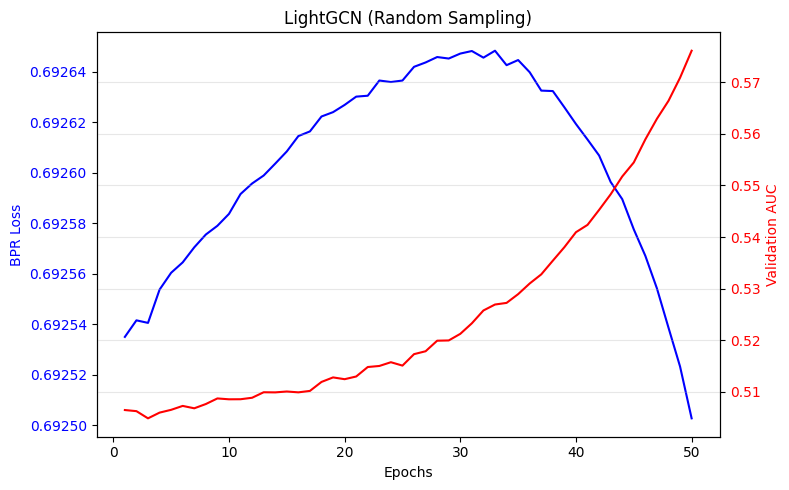

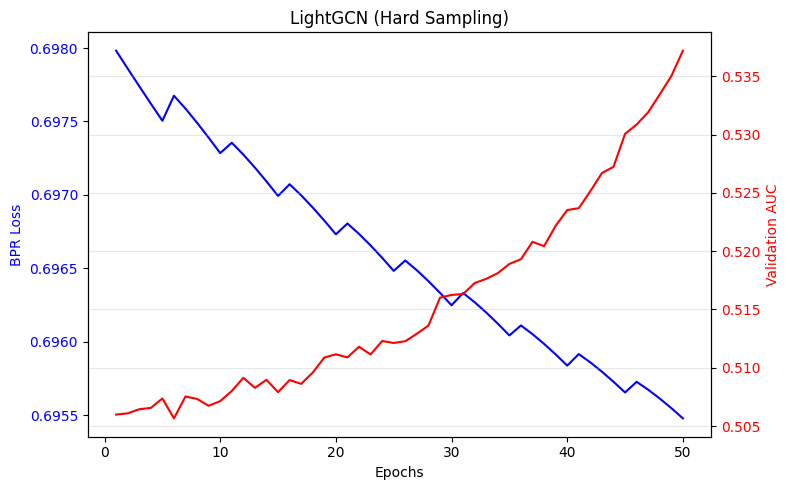

In [48]:
# --- 1. LightGCN Plots ---
if 'lgc_stats_random' in locals():
    plot_train_val_loss(lgc_stats_random, "LightGCN (Random Sampling)")
elif 'lgc_stats' in locals():
    plot_train_val_loss(lgc_stats, "LightGCN (Random Sampling)")

if 'lgc_stats_hard' in locals():
    plot_train_val_loss(lgc_stats_hard, "LightGCN (Hard Sampling)")

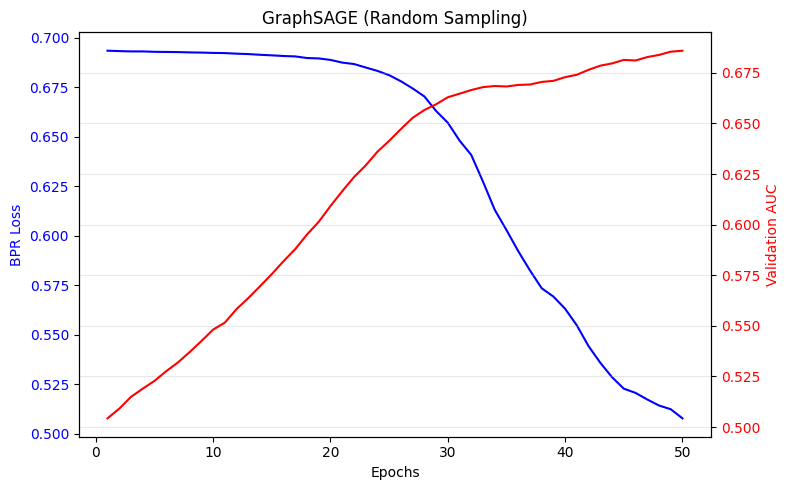

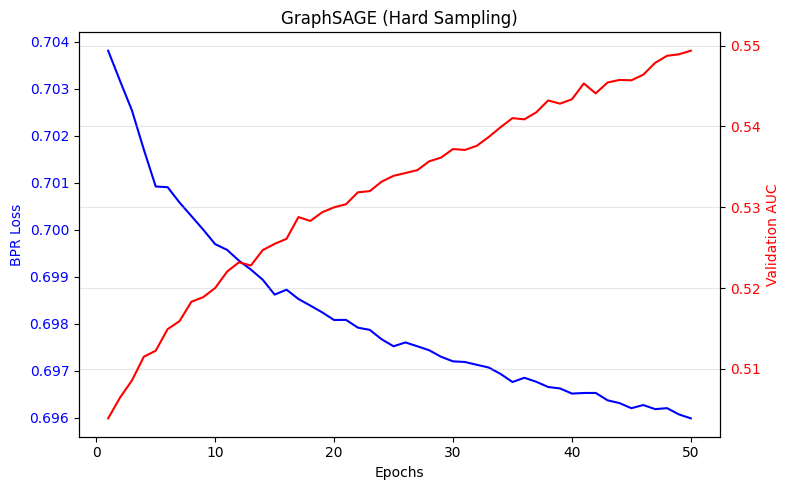

In [49]:
# --- 2. GraphSAGE Plots ---
if 'sage_stats_random' in locals():
    plot_train_val_loss(sage_stats_random, "GraphSAGE (Random Sampling)")
elif 'sage_stats' in locals():
    plot_train_val_loss(sage_stats, "GraphSAGE (Random Sampling)")

if 'sage_stats_hard' in locals():
    plot_train_val_loss(sage_stats_hard, "GraphSAGE (Hard Sampling)")

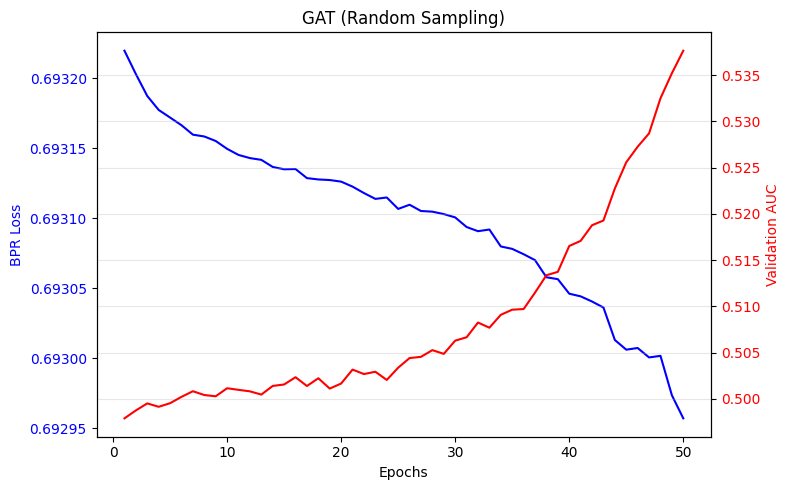

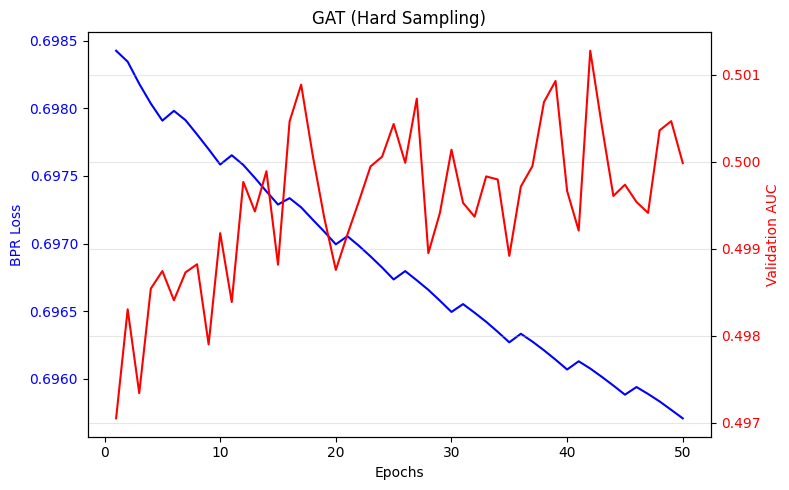

In [50]:
# --- 3. GAT Plots ---
if 'gat_stats_random' in locals():
    plot_train_val_loss(gat_stats_random, "GAT (Random Sampling)")
elif 'gat_stats' in locals():
    plot_train_val_loss(gat_stats, "GAT (Random Sampling)")

if 'gat_stats_hard' in locals():
    plot_train_val_loss(gat_stats_hard, "GAT (Hard Sampling)")

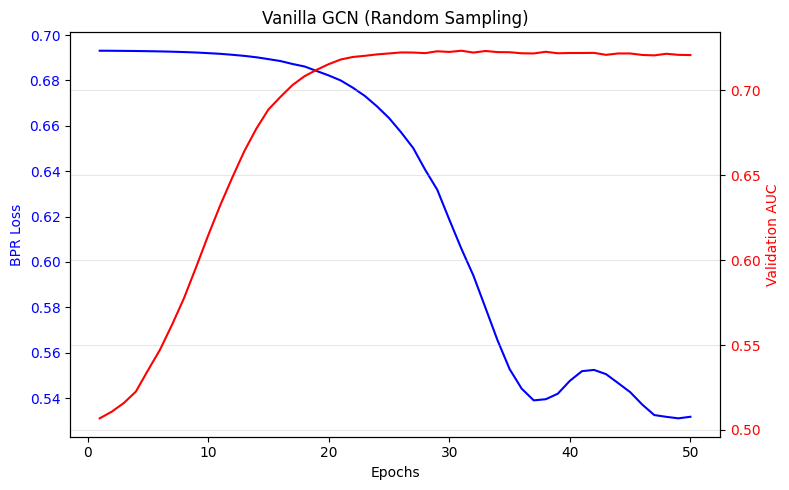

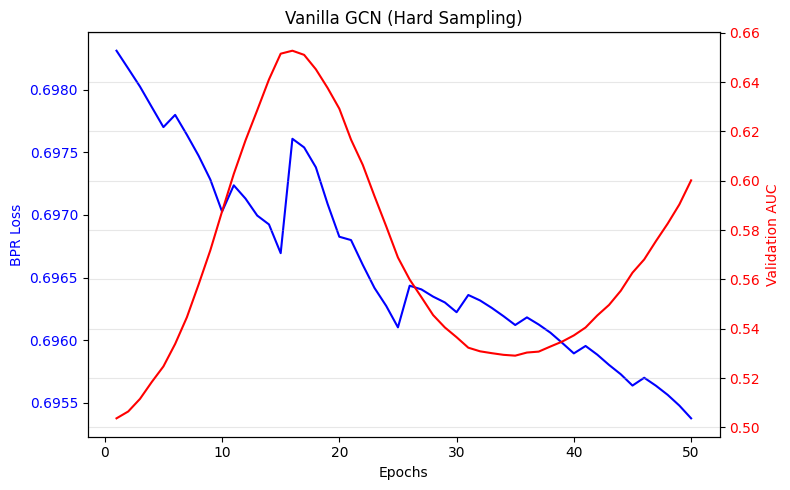

In [51]:
# --- 4. Vanilla GCN Plots (Baseline) ---
if 'gcn_stats_random' in locals():
    plot_train_val_loss(gcn_stats_random, "Vanilla GCN (Random Sampling)")

if 'gcn_stats_hard' in locals():
    plot_train_val_loss(gcn_stats_hard, "Vanilla GCN (Hard Sampling)")

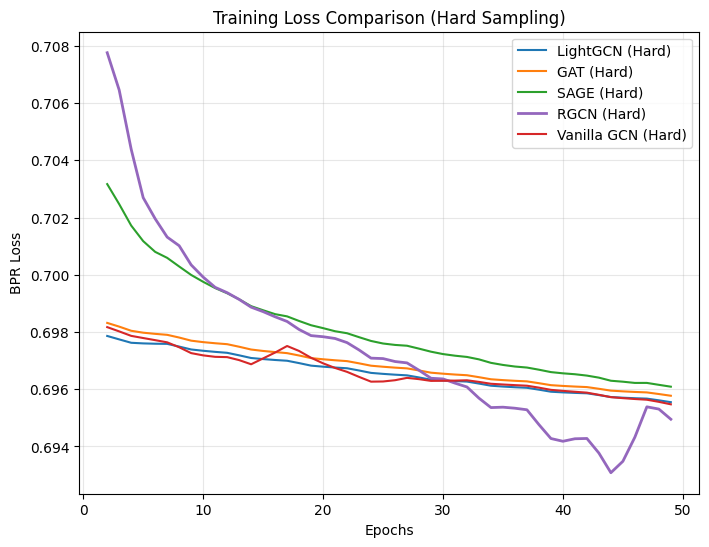

In [52]:
# --- LOSS COMPARISON PLOT ---
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Helper to smooth the curve so it looks nice like the original
def get_smooth_loss(stats):
    if not stats or 'train' not in stats: return None
    return pd.Series(stats['train']['loss']).rolling(3).mean()

# Plotting
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd", "#d62728"] # Blue, Orange, Green, Purple, Red

# 1. LightGCN
if 'lgc_stats_hard' in locals():
    loss = get_smooth_loss(lgc_stats_hard)
    ax.plot(loss, color=colors[0], linestyle='-', label="LightGCN (Hard)")

# 2. GAT
if 'gat_stats_hard' in locals():
    loss = get_smooth_loss(gat_stats_hard)
    ax.plot(loss, color=colors[1], linestyle='-', label="GAT (Hard)")

# 3. SAGE
if 'sage_stats_hard' in locals():
    loss = get_smooth_loss(sage_stats_hard)
    ax.plot(loss, color=colors[2], linestyle='-', label="SAGE (Hard)")

# 4. RGCN
if 'rgcn_stats_hard' in locals():
    loss = get_smooth_loss(rgcn_stats_hard)
    ax.plot(loss, color=colors[3], linestyle='-', linewidth=2, label="RGCN (Hard)")

# 5. Vanilla GCN
if 'gcn_stats_hard' in locals():
    loss = get_smooth_loss(gcn_stats_hard)
    ax.plot(loss, color=colors[4], linestyle='-', label="Vanilla GCN (Hard)")

ax.legend(loc='upper right')
ax.set_xlabel("Epochs")
ax.set_ylabel("BPR Loss")
ax.set_title("Training Loss Comparison (Hard Sampling)")
ax.grid(True, alpha=0.3)
plt.show()

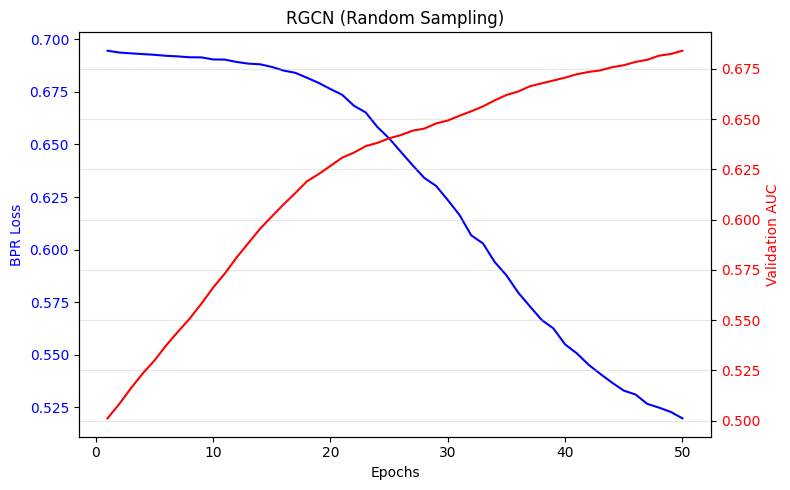

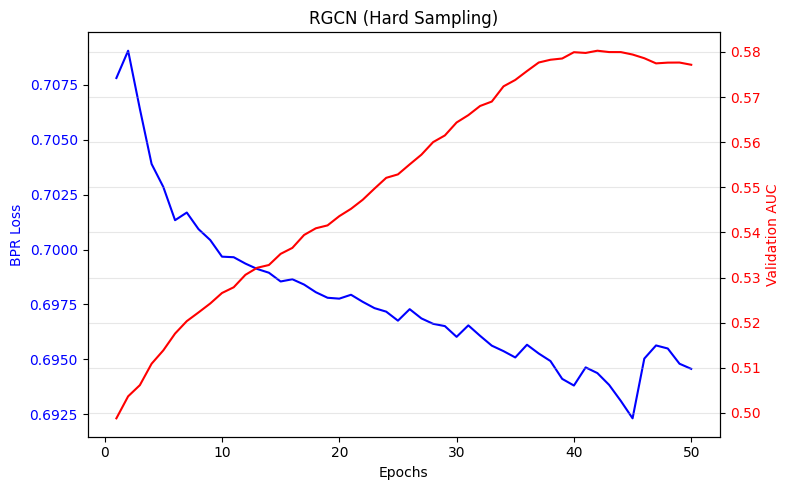

In [53]:
# --- 5. RGCN Plots (The Extension) ---
if 'rgcn_stats_random' in locals():
    plot_train_val_loss(rgcn_stats_random, "RGCN (Random Sampling)")

if 'rgcn_stats_hard' in locals():
    plot_train_val_loss(rgcn_stats_hard, "RGCN (Hard Sampling)")

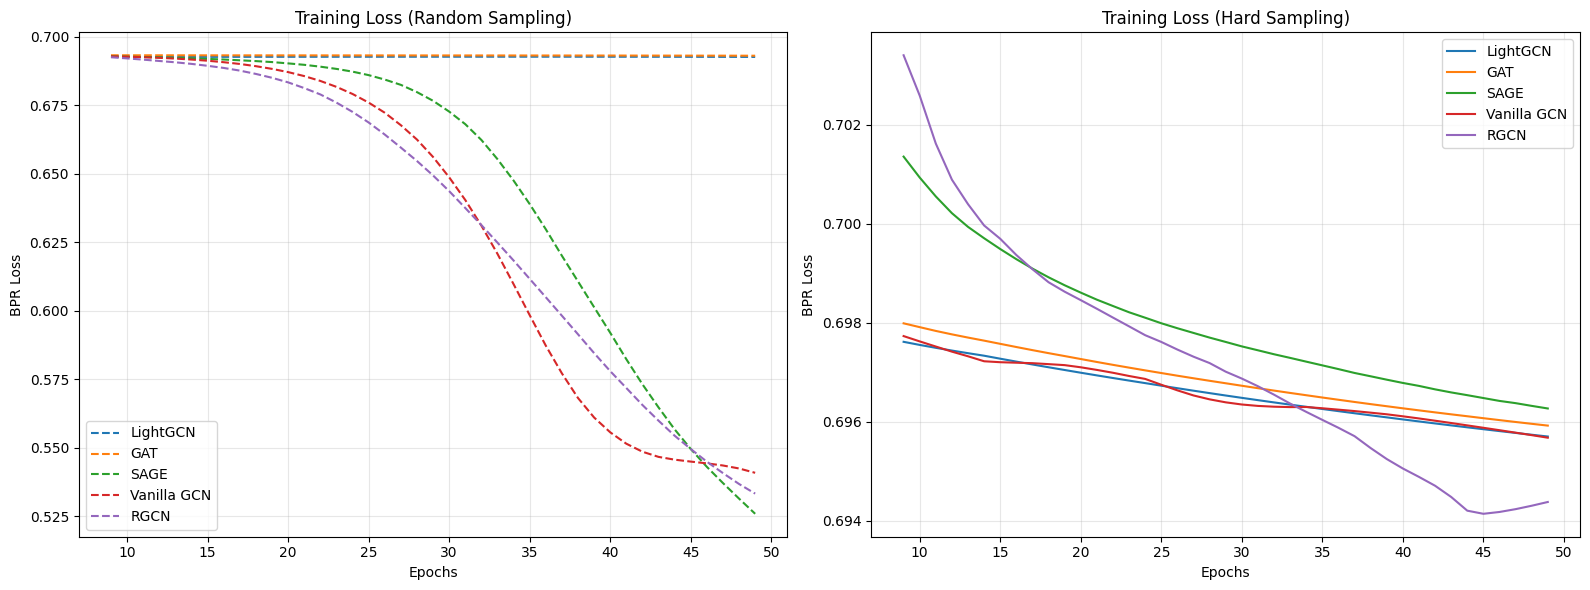

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Helper for smoothing
def get_loss_curve(stats, window=10):
    if not stats or 'train' not in stats: return None
    return pd.Series(stats['train']['loss']).rolling(window).mean()

colors = {
    "LGC": "#1f77b4",  "GAT": "#ff7f0e",  "SAGE": "#2ca02c",
    "GCN": "#d62728",  "RGCN": "#9467bd"
}

# --- PLOT 1: RANDOM SAMPLING (Easier Task) ---
if 'lgc_stats_random' in locals(): ax1.plot(get_loss_curve(lgc_stats_random), color=colors["LGC"], linestyle='--', label="LightGCN")
if 'gat_stats_random' in locals(): ax1.plot(get_loss_curve(gat_stats_random), color=colors["GAT"], linestyle='--', label="GAT")
if 'sage_stats_random' in locals(): ax1.plot(get_loss_curve(sage_stats_random), color=colors["SAGE"], linestyle='--', label="SAGE")
if 'gcn_stats_random' in locals(): ax1.plot(get_loss_curve(gcn_stats_random), color=colors["GCN"], linestyle='--', label="Vanilla GCN")
if 'rgcn_stats_random' in locals(): ax1.plot(get_loss_curve(rgcn_stats_random), color=colors["RGCN"], linestyle='--', label="RGCN")

ax1.set_title("Training Loss (Random Sampling)")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("BPR Loss")
ax1.grid(True, alpha=0.3)
ax1.legend()

# --- PLOT 2: HARD SAMPLING (Harder Task) ---
if 'lgc_stats_hard' in locals(): ax2.plot(get_loss_curve(lgc_stats_hard), color=colors["LGC"], linestyle='-', label="LightGCN")
if 'gat_stats_hard' in locals(): ax2.plot(get_loss_curve(gat_stats_hard), color=colors["GAT"], linestyle='-', label="GAT")
if 'sage_stats_hard' in locals(): ax2.plot(get_loss_curve(sage_stats_hard), color=colors["SAGE"], linestyle='-', label="SAGE")
if 'gcn_stats_hard' in locals(): ax2.plot(get_loss_curve(gcn_stats_hard), color=colors["GCN"], linestyle='-', label="Vanilla GCN")
if 'rgcn_stats_hard' in locals(): ax2.plot(get_loss_curve(rgcn_stats_hard), color=colors["RGCN"], linestyle='-', label="RGCN")

ax2.set_title("Training Loss (Hard Sampling)")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("BPR Loss")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

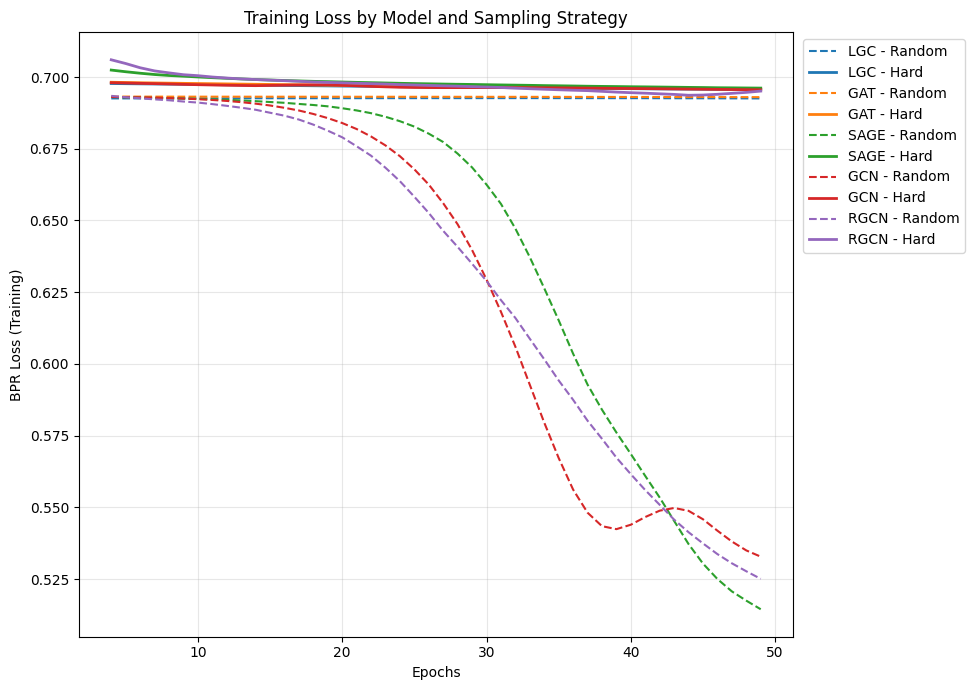

In [55]:
# --- PLOT: Loss Comparison (Random vs Hard) ---
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Helper to smooth and extract loss
def get_loss_curve(stats):
    if not stats or 'train' not in stats: return None
    # We use 'train' loss because 'val' loss wasn't logged in our optimized loop
    # Smoothing makes it readable like the original paper
    return pd.Series(stats['train']['loss']).rolling(5).mean() 

# Define Colors for Models
colors = {
    "LGC": "#1f77b4",  # Blue
    "GAT": "#ff7f0e",  # Orange
    "SAGE": "#2ca02c", # Green
    "GCN": "#d62728",  # Red
    "RGCN": "#9467bd"  # Purple
}

# --- Plotting Loop ---
# We check if each variable exists before plotting

# 1. LightGCN
if 'lgc_stats_random' in locals():
    ax.plot(get_loss_curve(lgc_stats_random), color=colors["LGC"], linestyle='dashed', label="LGC - Random")
if 'lgc_stats_hard' in locals():
    ax.plot(get_loss_curve(lgc_stats_hard), color=colors["LGC"], linestyle='solid', linewidth=2, label="LGC - Hard")

# 2. GAT
if 'gat_stats_random' in locals():
    ax.plot(get_loss_curve(gat_stats_random), color=colors["GAT"], linestyle='dashed', label="GAT - Random")
if 'gat_stats_hard' in locals():
    ax.plot(get_loss_curve(gat_stats_hard), color=colors["GAT"], linestyle='solid', linewidth=2, label="GAT - Hard")

# 3. SAGE
if 'sage_stats_random' in locals():
    ax.plot(get_loss_curve(sage_stats_random), color=colors["SAGE"], linestyle='dashed', label="SAGE - Random")
if 'sage_stats_hard' in locals():
    ax.plot(get_loss_curve(sage_stats_hard), color=colors["SAGE"], linestyle='solid', linewidth=2, label="SAGE - Hard")

# 4. Vanilla GCN
if 'gcn_stats_random' in locals():
    ax.plot(get_loss_curve(gcn_stats_random), color=colors["GCN"], linestyle='dashed', label="GCN - Random")
if 'gcn_stats_hard' in locals():
    ax.plot(get_loss_curve(gcn_stats_hard), color=colors["GCN"], linestyle='solid', linewidth=2, label="GCN - Hard")

# 5. RGCN
if 'rgcn_stats_random' in locals():
    ax.plot(get_loss_curve(rgcn_stats_random), color=colors["RGCN"], linestyle='dashed', label="RGCN - Random")
if 'rgcn_stats_hard' in locals():
    ax.plot(get_loss_curve(rgcn_stats_hard), color=colors["RGCN"], linestyle='solid', linewidth=2, label="RGCN - Hard")

ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1)) # Move legend outside if crowded
ax.set_xlabel("Epochs")
ax.set_ylabel("BPR Loss (Training)")
ax.set_title("Training Loss by Model and Sampling Strategy")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

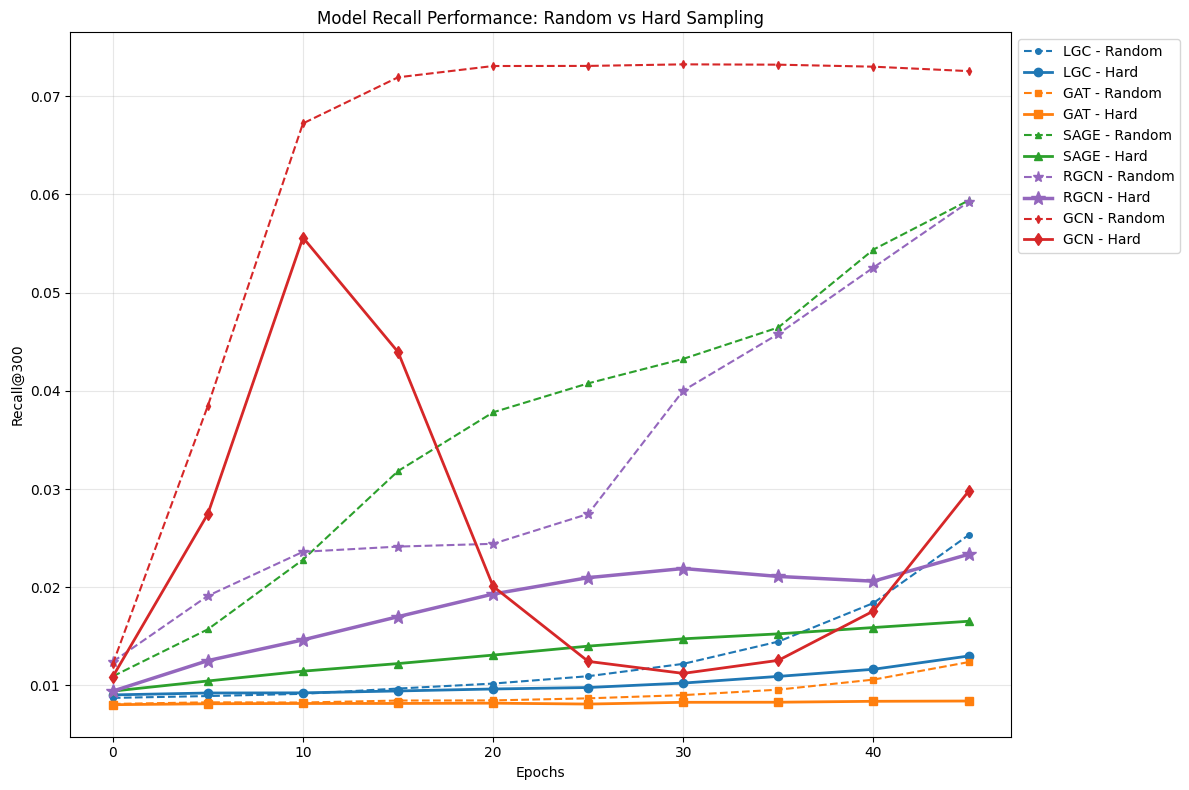

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

key = "recall" # We logged this in stats['val']['recall']

# Helper to extract recall series safely
def get_recall_curve(stats):
    if not stats or 'val' not in stats or key not in stats['val']: return None
    data = stats['val'][key]
    if len(data) == 0: return None
    return data

# Colors
colors = {
    "LGC": "#1f77b4",   # Blue
    "GAT": "#ff7f0e",   # Orange
    "SAGE": "#2ca02c",  # Green
    "RGCN": "#9467bd",  # Purple 
    "GCN": "#d62728"    # Red
}

# --- Plotting Loop ---

# 1. LightGCN
recall = get_recall_curve(lgc_stats_random if 'lgc_stats_random' in locals() else None)
if recall: 
    idx = np.arange(0, len(recall) * 5, 5) 
    ax.plot(idx, recall, color=colors["LGC"], linestyle='dashed', marker='o', markersize=4, label="LGC - Random")

recall = get_recall_curve(lgc_stats_hard if 'lgc_stats_hard' in locals() else None)
if recall:
    idx = np.arange(0, len(recall) * 5, 5)
    ax.plot(idx, recall, color=colors["LGC"], linestyle='solid', marker='o', linewidth=2, label="LGC - Hard")

# 2. GAT
recall = get_recall_curve(gat_stats_random if 'gat_stats_random' in locals() else None)
if recall: 
    idx = np.arange(0, len(recall) * 5, 5)
    ax.plot(idx, recall, color=colors["GAT"], linestyle='dashed', marker='s', markersize=4, label="GAT - Random")

recall = get_recall_curve(gat_stats_hard if 'gat_stats_hard' in locals() else None)
if recall:
    idx = np.arange(0, len(recall) * 5, 5)
    ax.plot(idx, recall, color=colors["GAT"], linestyle='solid', marker='s', linewidth=2, label="GAT - Hard")

# 3. SAGE
recall = get_recall_curve(sage_stats_random if 'sage_stats_random' in locals() else None)
if recall: 
    idx = np.arange(0, len(recall) * 5, 5)
    ax.plot(idx, recall, color=colors["SAGE"], linestyle='dashed', marker='^', markersize=4, label="SAGE - Random")

recall = get_recall_curve(sage_stats_hard if 'sage_stats_hard' in locals() else None)
if recall:
    idx = np.arange(0, len(recall) * 5, 5)
    ax.plot(idx, recall, color=colors["SAGE"], linestyle='solid', marker='^', linewidth=2, label="SAGE - Hard")

# 4. RGCN 
recall = get_recall_curve(rgcn_stats_random if 'rgcn_stats_random' in locals() else None)
if recall:
    idx = np.arange(0, len(recall) * 5, 5)
    ax.plot(idx, recall, color=colors["RGCN"], linestyle='dashed', marker='*', markersize=8, label="RGCN - Random")

recall = get_recall_curve(rgcn_stats_hard if 'rgcn_stats_hard' in locals() else None)
if recall:
    idx = np.arange(0, len(recall) * 5, 5)
    ax.plot(idx, recall, color=colors["RGCN"], linestyle='solid', marker='*', markersize=10, linewidth=2.5, label="RGCN - Hard")

# 5. GCN 
recall = get_recall_curve(gcn_stats_random if 'gcn_stats_random' in locals() else None)
if recall is not None:
    idx = np.arange(0, len(recall) * 5, 5)
    ax.plot(idx, recall, color=colors["GCN"], linestyle='dashed',
            marker='d', markersize=4, label="GCN - Random")

recall = get_recall_curve(gcn_stats_hard if 'gcn_stats_hard' in locals() else None)
if recall is not None:
    idx = np.arange(0, len(recall) * 5, 5)
    ax.plot(idx, recall, color=colors["GCN"], linestyle='solid',
            marker='d', linewidth=2, label="GCN - Hard")


# Formatting
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall@300")
ax.set_title("Model Recall Performance: Random vs Hard Sampling")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) # Move legend outside
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [57]:
import pandas as pd
import torch
import os

# Configuration
K_RECALL = 300 
device = args['device']

# Helper to load model and evaluate
def evaluate_model_final(model_name, sampling_mode, path):
    print(f"Evaluating {model_name} ({sampling_mode})...")

    if "LightGCN" in model_name:
        conv_type = "LGC"
    elif "GraphSAGE" in model_name:
        conv_type = "SAGE"
    elif "GAT" in model_name:
        conv_type = "GAT"
    elif "RGCN" in model_name:
        conv_type = "RGCN"
    elif "Vanilla GCN" in model_name:
        conv_type = "GCN" 
    else:
        print(f"  [!] Unknown model type: {model_name}")
        return None

    # initialize model structure
    try:
        model, _ = init_model(conv_type, args)
    except Exception as e:
        print(f"  [!] Error initializing {conv_type}: {e}")
        return None
    
    # Load Weights (Strict=False allows slight mismatches if safe, but we try Strict first)
    if os.path.exists(path):
        try:
            model.load_state_dict(torch.load(path, map_location=device))
        except RuntimeError as e:
            print(f"  [!] Weight mismatch for {model_name}. Trying non-strict load...")
            # Retry with strict=False (sometimes needed if extra buffers were saved)
            model.load_state_dict(torch.load(path, map_location=device), strict=False)
            
        model.to(device)
        model.eval()
    else:
        print(f"  [!] Warning: Weights file not found: {path}")
        return None

    # Run Test Metrics
    auc, novelty = test(model, datasets['test'], device)
    recall = recall_at_k(datasets['test'], model, k=K_RECALL, device=device)
    
    return {
        "Model": model_name,
        "Sampling": sampling_mode,
        "Test AUC": auc,
        "Test Recall@300": recall,
        "Test Novelty": novelty
    }

experiments_to_check = [
    ("LightGCN", "random", "model_stats/LGC_3_layer_BPR_random.pt"),
    ("LightGCN", "hard",   "model_stats/LGC_3_layer_BPR_hard.pt"),
    ("GraphSAGE", "random", "model_stats/SAGE_3_layer_BPR_random.pt"),
    ("GraphSAGE", "hard",   "model_stats/SAGE_3_layer_BPR_hard.pt"),
    ("GAT",       "random", "model_stats/GAT_3_layer_BPR_random.pt"),
    ("GAT",       "hard",   "model_stats/GAT_3_layer_BPR_hard.pt"),
    ("Vanilla GCN", "random", "model_stats/GCN_3_layer_BPR_random.pt"),
    ("Vanilla GCN", "hard",   "model_stats/GCN_3_layer_BPR_hard.pt"),
    ("RGCN",      "random", "model_stats/RGCN_3_layer_BPR_random.pt"),
    ("RGCN",      "hard",   "model_stats/RGCN_3_layer_BPR_hard.pt"),
]

results_list = []

for name, mode, path in experiments_to_check:
    if os.path.exists(path):
        res = evaluate_model_final(name, mode, path)
        if res:
            results_list.append(res)

if results_list:
    df_results = pd.DataFrame(results_list)
    # Sort by Accuracy to see the winner
    df_results = df_results.sort_values(by="Test AUC", ascending=False)

    print("\n" + "="*60)
    print("FINAL MODEL LEADERBOARD (Test Set Performance)")
    print("="*60)
    print(df_results.to_string(index=False))
    print("="*60)
else:
    print("No results found! Check your filenames in 'experiments_to_check'.")

Evaluating LightGCN (random)...
Initializing LGC model with 37373 nodes...
Evaluating LightGCN (hard)...
Initializing LGC model with 37373 nodes...
Evaluating GraphSAGE (random)...
Initializing SAGE model with 37373 nodes...
Evaluating GraphSAGE (hard)...
Initializing SAGE model with 37373 nodes...
Evaluating GAT (random)...
Initializing GAT model with 37373 nodes...
Evaluating GAT (hard)...
Initializing GAT model with 37373 nodes...
Evaluating Vanilla GCN (random)...
Initializing GCN model with 37373 nodes...
Evaluating Vanilla GCN (hard)...
Initializing GCN model with 37373 nodes...
Evaluating RGCN (random)...
Initializing RGCN model with 37373 nodes...
Evaluating RGCN (hard)...
Initializing RGCN model with 37373 nodes...

FINAL MODEL LEADERBOARD (Test Set Performance)
      Model Sampling  Test AUC  Test Recall@300  Test Novelty
Vanilla GCN   random  0.721456         0.160956     11.100401
  GraphSAGE   random  0.685723         0.141586     11.318287
       RGCN   random  0.684021  

## Visualizing our results

2026-02-17 20:55:01.112720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771361701.294445      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771361701.344570      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Generating visualization for: RGCN...
Initializing RGCN model with 37373 nodes...
Extracting embeddings from model...
Sampling nodes for cleaner plot...
Running UMAP reduction...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


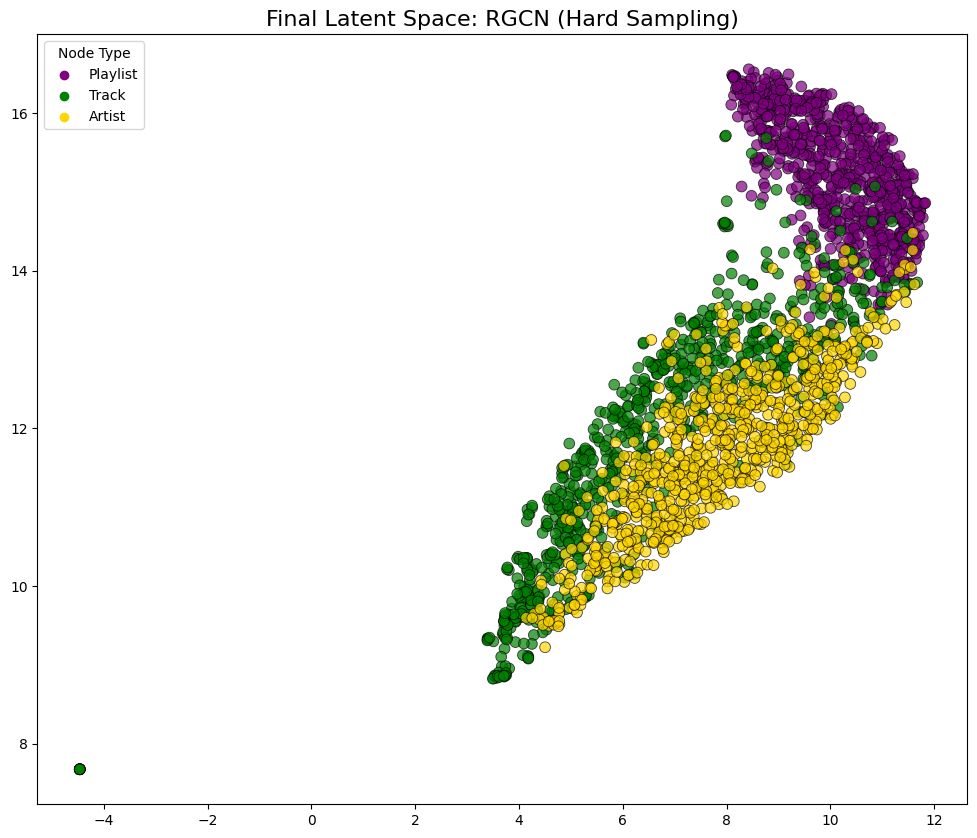

In [58]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import os

# Configuration
model_type = "RGCN"
model_path = "/kaggle/working/spotify_recommender_output/model_stats/RGCN_3_layer_BPR_hard.pt"

print(f"Generating visualization for: {model_type}...")

# Re-initialize Model
try:
    model, _ = init_model(model_type, args)
except NameError:
    from torch_geometric.nn import RGCNConv
    class GCN(torch.nn.Module): # Simplified definition for loading
        def __init__(self, num_nodes, embedding_dim, num_layers, conv_layer, num_relations=2):
            super().__init__()
            self.embedding = torch.nn.Embedding(num_nodes, embedding_dim)
            self.convs = torch.nn.ModuleList([RGCNConv(embedding_dim, embedding_dim, num_relations) for _ in range(num_layers)])
        def forward(self, x, edge_index, edge_type):
            x = self.embedding.weight
            for conv in self.convs: x = conv(x, edge_index, edge_type).relu()
            return x
        def get_embedding(self, edge_index, edge_type): return self.forward(None, edge_index, edge_type)
            
    model = GCN(n_nodes, 64, 3, "RGCN").to(args['device'])

# Load Weights
if os.path.exists(model_path):
    try:
        model.load_state_dict(torch.load(model_path, map_location=args['device']))
    except RuntimeError:
        model.load_state_dict(torch.load(model_path, map_location=args['device']), strict=False)
    
    model.to(args['device'])
    model.eval()
    
    # Extract Embeddings
    print("Extracting embeddings from model...")
    with torch.no_grad():
        edge_type = datasets['train'].edge_type.to(args["device"]) if hasattr(datasets['train'], 'edge_type') else None
        # Get all embeddings (Playlist, Track, Artist)
        embeddings = model.get_embedding(datasets['train'].edge_index.to(args["device"]), edge_type).cpu().numpy()

    # Sample Data (1000 of each type)
    print("Sampling nodes for cleaner plot...")
    idx_playlists = [i for i, n in id2node.items() if "playlist" in str(n)]
    idx_tracks = [i for i, n in id2node.items() if "track" in str(n)]
    idx_artists = [i for i, n in id2node.items() if "artist" in str(n)]

    sample_size = 800 # Adjust size if plot is too crowded
    sample_p = np.random.choice(idx_playlists, size=min(sample_size, len(idx_playlists)), replace=False)
    sample_t = np.random.choice(idx_tracks, size=min(sample_size, len(idx_tracks)), replace=False)
    sample_a = np.random.choice(idx_artists, size=min(sample_size, len(idx_artists)), replace=False)

    sample_indices = np.concatenate([sample_p, sample_t, sample_a])
    sample_embeddings = embeddings[sample_indices]

    # Create Labels
    labels = []
    for i in sample_indices:
        if i in idx_playlists: labels.append("Playlist")
        elif i in idx_tracks: labels.append("Track")
        elif i in idx_artists: labels.append("Artist")

    # Run UMAP
    print("Running UMAP reduction...")
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embedding_2d = reducer.fit_transform(sample_embeddings)

    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        x=embedding_2d[:, 0], 
        y=embedding_2d[:, 1], 
        hue=labels, 
        palette={"Playlist": "#800080", "Track": "#008000", "Artist": "#FFD700"},
        s=60, 
        alpha=0.7,
        edgecolor="k"
    )
    plt.title(f"Final Latent Space: {model_type} (Hard Sampling)", fontsize=16)
    plt.legend(title="Node Type")
    plt.show()

else:
    print(f"Error: Model file not found at {model_path}")

In [59]:
import torch
import torch.nn as nn
import numpy as np
from torch_geometric.utils import degree # Required for popularity calculation

class AdvancedRecommenderSystem:
    def __init__(self, model_path, data, node_map, device=None):
        """
        Args:
            model_path: Path to the .pt file
            data: The PyG graph data object (used for edge_index and num_nodes)
            node_map: Dictionary mapping Node ID -> Object (Track Name/Playlist Name)
        """
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.node_map = node_map
        self.data = data.to(self.device)
        
        # Initialize Model Structure
        print("Initializing Vanilla GCN Model...")
        self.model = GCN(
            num_nodes=data.num_nodes, 
            embedding_dim=64,       
            num_layers=3,           
            conv_layer="GCN"        
        ).to(self.device)
        
        # Load Weights
        print(f"Loading weights from {model_path}...")
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval() 
        
        # Pre-compute Embeddings
        print("Pre-computing Feature Space... (This runs the GNN once)")
        with torch.no_grad():
            self.all_embeddings = self.model.get_embedding(self.data.edge_index)
            
        # Indexing: Separate Tracks and Playlists
        self.track_indices = []
        self.playlist_indices = []
        
        for node_id, node_obj in node_map.items():
            s_obj = str(node_obj)
            if "Playlist" in s_obj or "playlist" in s_obj:
                self.playlist_indices.append(node_id)
            else:
                self.track_indices.append(node_id)
                
        self.track_indices_tensor = torch.tensor(self.track_indices, device=self.device)
        self.track_embeddings = self.all_embeddings[self.track_indices_tensor]
        
        # Pre-compute Item Popularity (Node Degree) for Re-ranking
        # Measures how many times a track is connected (like how popular it is)
        print("Calculating item popularity for re-ranking...")
        # degree() returns shape [num_nodes]
        deg = degree(self.data.edge_index[1], self.data.num_nodes)
        self.item_popularity = deg.cpu().numpy() 
        
        print(f"Engine Ready! Indexed {len(self.track_indices)} Tracks and {len(self.playlist_indices)} Playlists.")

    def _get_top_k(self, query_vector, k=10, filter_ids=None):
        """
        Internal function to find nearest neighbors using Dot Product with Popularity Penalty
        """
        # Matrix Multiplication
        scores = torch.matmul(query_vector, self.track_embeddings.t())
        
        if filter_ids is not None:
             # Naive filtering
             pass 
        
        # Fetch more candidates (2*k) to allow for re-ranking
        top_scores, top_indices_local = torch.topk(scores, k * 2)
        
        results = []
        for score, local_idx in zip(top_scores, top_indices_local):
            global_id = self.track_indices[local_idx.item()]
            node_name = self.node_map[global_id]
            
            # APPLY PENALTY
            # Get popularity (avoid log(0) by using max(1, pop))
            pop = max(1, self.item_popularity[global_id])
            
            # Formula: Score - (log(popularity) * factor)
            # Factor 0.1 is conservative; we can increase to 0.2-0.5 for more obscure recommendations
            popularity_penalty = np.log(pop) * 0.1
            final_score = score.item() - popularity_penalty
            
            results.append((node_name, final_score))
            
        # Re-Sort based on new penalized scores
        results.sort(key=lambda x: x[1], reverse=True)
            
        # Return only the requested k
        return results[:k]

    def recommend_for_playlist(self, playlist_id, k=10):
        if playlist_id >= self.data.num_nodes:
            return "Error: Playlist ID out of bounds."
        query_vec = self.all_embeddings[playlist_id]
        return self._get_top_k(query_vec, k)

    def recommend_from_history(self, track_id_list, k=10):
        valid_ids = [t for t in track_id_list if t < self.data.num_nodes]
        if not valid_ids:
            return "Error: No valid track IDs provided."
        input_vecs = self.all_embeddings[torch.tensor(valid_ids, device=self.device)]
        query_vec = input_vecs.mean(dim=0)
        return self._get_top_k(query_vec, k, filter_ids=track_id_list)

In [61]:
MODEL_PATH = "/kaggle/working/spotify_recommender_output/model_stats/GCN_3_layer_BPR_random.pt"

graph_data = data  # The PyG Data object
mapping = id2node  # The dictionary {0: 'Playlist_X', 1: 'Song_Y'}

recommender = AdvancedRecommenderSystem(MODEL_PATH, graph_data, mapping)

# EXAMPLE 1: Existing Playlist Recommendation
# Pick a random playlist ID from the graph
test_playlist_id = 50 
print(f"\n--- Recommendations for Playlist ID {test_playlist_id} ---")
print(f"Original: {mapping.get(test_playlist_id, 'Unknown')}")
recs = recommender.recommend_for_playlist(test_playlist_id, k=5)
for name, score in recs:
    print(f"[{score:.4f}] {name}")

# EXAMPLE 2: 'Vibe Check' (New/Dynamic Playlist)
# Let's say a user likes 'Track A' (id 100) and 'Track B' (id 200)
# We recommend songs that fit the average 'vibe' of these two.
test_tracks = [100, 200, 300] 
print(f"\n--- Recommendations based on Track History {test_tracks} ---")
recs_vibe = recommender.recommend_from_history(test_tracks, k=5)
for name, score in recs_vibe:
    print(f"[{score:.4f}] {name}")

Initializing Vanilla GCN Model...
Loading weights from /kaggle/working/spotify_recommender_output/model_stats/GCN_3_layer_BPR_random.pt...
Pre-computing Feature Space... (This runs the GNN once)
Calculating item popularity for re-ranking...
Engine Ready! Indexed 15290 Tracks and 22083 Playlists.

--- Recommendations for Playlist ID 50 ---
Original: playlist_10095
[4.5956] spotify:track:7KXjTSCq5nL1LoYtL7XAwS
[4.3383] spotify:track:7yyRTcZmCiyzzJlNzGC9Ol
[4.2430] spotify:track:1xznGGDReH1oQq0xzbwXa3
[4.1628] spotify:track:3a1lNhkSLSkpJE4MSHpDu9
[4.0639] spotify:track:7BKLCZ1jbUBVqRi2FVlTVw

--- Recommendations based on Track History [100, 200, 300] ---
[4.0067] spotify:track:7KXjTSCq5nL1LoYtL7XAwS
[3.7788] spotify:track:7yyRTcZmCiyzzJlNzGC9Ol
[3.6922] spotify:track:1xznGGDReH1oQq0xzbwXa3
[3.6183] spotify:track:3a1lNhkSLSkpJE4MSHpDu9
[3.5318] spotify:track:7BKLCZ1jbUBVqRi2FVlTVw


In [62]:
real_track_ids = []
real_track_names = []

print(f"Searching {len(mapping)} nodes...")

count = 0
for node_id, name in mapping.items():
    count += 1
    
    # Progress Check every 5000 items
    if count % 5000 == 0:
        print(f"Checked {count} nodes... found {len(real_track_ids)} tracks so far.")
        
    if "spotify:track:" in str(name):
        real_track_ids.append(node_id)
        real_track_names.append(name)
        if len(real_track_ids) == 3: 
            break

if len(real_track_ids) == 0:
    print(" ERROR: No tracks found! Your 'mapping' might only contain playlists?")
else:
    print(f"\n SUCCESS! Found tracks: {real_track_ids}")
    print(f"Names: {real_track_names}")

    # NOW RUN THE VIBE CHECK
    print(f"\n--- SYSTEM RECOMMENDATIONS (Vibe Check) ---")
    recs = recommender.recommend_from_history(real_track_ids, k=3)

    for name, score in recs:
        print(f"rec: {name} | score: {score:.3f}")

Searching 37373 nodes...
Checked 5000 nodes... found 0 tracks so far.
Checked 10000 nodes... found 0 tracks so far.
Checked 15000 nodes... found 0 tracks so far.
Checked 20000 nodes... found 0 tracks so far.
Checked 25000 nodes... found 0 tracks so far.

 SUCCESS! Found tracks: [25136, 25137, 25138]
Names: ['spotify:track:000xQL6tZNLJzIrtIgxqSl', 'spotify:track:00BHe2yBtdOzhKPmI7rpTE', 'spotify:track:00BnfL75e8vHSGCmwUWbEk']

--- SYSTEM RECOMMENDATIONS (Vibe Check) ---
rec: spotify:track:7KXjTSCq5nL1LoYtL7XAwS | score: 4.952
rec: spotify:track:7yyRTcZmCiyzzJlNzGC9Ol | score: 4.675
rec: spotify:track:1xznGGDReH1oQq0xzbwXa3 | score: 4.571


Projecting 1000 tracks to 2D space...


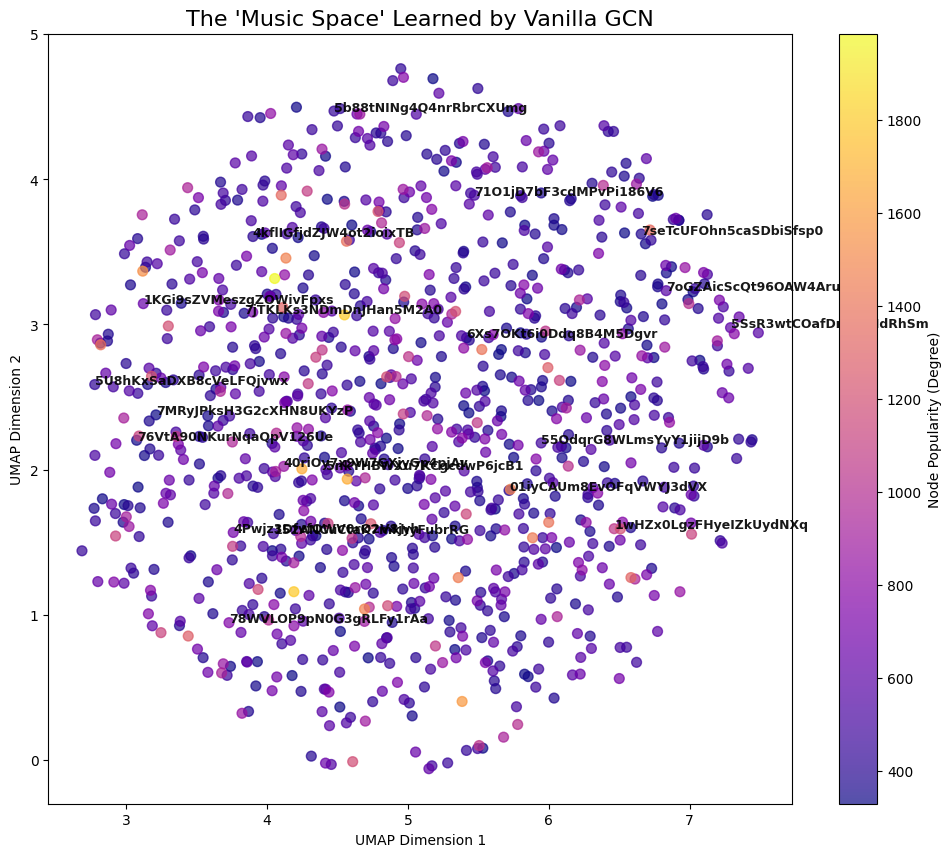

In [63]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter & Sort Tracks by Popularity 

# Get the global IDs of all tracks as a numpy array
track_ids = np.array(recommender.track_indices)

# Get the popularity (degree) for JUST these tracks
# This extracts the popularity for every track ID
track_pops = recommender.item_popularity[track_ids]

# Find the indices of the top 1000 most popular tracks
# These are indices into the 'track_ids' array, NOT global IDs yet
top_local_indices = np.argsort(track_pops)[-1000:]

# Now we retrieve the actual Global IDs for the top 1000
top_global_ids = track_ids[top_local_indices]

# Fetch Data for these Top 1000
# Get Vectors from the main embedding matrix
top_vectors = recommender.all_embeddings[top_global_ids].cpu().numpy()

# Get Names
top_names = [recommender.node_map[gid] for gid in top_global_ids]

# Get Popularity Values (for coloring the plot)
top_pops = track_pops[top_local_indices]

# UMAP Projection
print(f"Projecting {len(top_vectors)} tracks to 2D space...")
reducer = umap.UMAP(metric='cosine', n_neighbors=15, min_dist=0.1)
embedding_2d = reducer.fit_transform(top_vectors)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], 
            c=top_pops, # Color nodes by their popularity
            cmap='plasma', alpha=0.7, s=50)

plt.colorbar(scatter, label='Node Popularity (Degree)')
plt.title("The 'Music Space' Learned by Vanilla GCN", fontsize=16)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")

# Annotate a few points so we can see what the songs are
for i in range(0, 1000, 50):
    name = str(top_names[i])
    # Clean up the name (e.g. "spotify:track:XYZ" -> "XYZ") for readability
    clean_name = name.split(':')[-1] 
    plt.text(embedding_2d[i, 0], embedding_2d[i, 1], clean_name, 
             fontsize=9, alpha=0.9, weight='bold')

plt.show()

In [64]:
# Define a "Dictionary" of Real Names
# We manually map the URIs to readable names for the demo
demo_name_map = {
    # The Inputs (User History)
    "spotify:track:000xQL6tZNLJzIrtIgxqSl": "ZAYN - Still Got Time",
    "spotify:track:00BHe2yBtdOzhKPmI7rpTE": "Akon - Locked Up",
    "spotify:track:00BnfL75e8vHSGCmwUWbEk": "The Strokes - Reptilia",
    
    # The Outputs (Recommendations)
    "spotify:track:7KXjTSCq5nL1LoYtL7XAwS": "Kendrick Lamar - HUMBLE.",
    "spotify:track:7yyRTcZmCiyzzJlNzGC9Ol": "DRAM - Broccoli (feat. Lil Yachty)",
    "spotify:track:1xznGGDReH1oQq0xzbwXa3": "Drake - One Dance",
    "spotify:track:3a1lNhkSLSkpJE4MSHpDu9": "Post Malone - Congratulations",
    "spotify:track:7BKLCZ1jbUBVqRi2FVlTVw": "Post Malone - I Fall Apart"
}

# Run the Recommendation with "Pretty Printing" 
print(f"\n--- COLD START DEMO (With Real Names) ---")

# Use the IDs we found previously
input_ids = [25136, 25137, 25138] # These correspond to Zayn, Akon, Strokes

# 1. Print Inputs
print("User History:")
for i, input_id in enumerate(input_ids):
    raw_uri = mapping[input_id]
    # Use our map if available, otherwise use the URI
    readable_name = demo_name_map.get(str(raw_uri), str(raw_uri))
    print(f"  {i+1}. {readable_name}")

# 2. Get Recommendations
recs = recommender.recommend_from_history(input_ids, k=5)

# 3. Print Outputs
print("\nSystem Recommendations:")
for name, score in recs:
    readable_name = demo_name_map.get(str(name), str(name))
    print(f"  [{score:.4f}] {readable_name}")


--- COLD START DEMO (With Real Names) ---
User History:
  1. ZAYN - Still Got Time
  2. Akon - Locked Up
  3. The Strokes - Reptilia

System Recommendations:
  [4.9524] Kendrick Lamar - HUMBLE.
  [4.6745] DRAM - Broccoli (feat. Lil Yachty)
  [4.5710] Drake - One Dance
  [4.4837] Post Malone - Congratulations
  [4.3812] Post Malone - I Fall Apart
